In [1]:
# Import the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency

In [2]:
loan_data = pd.read_csv('loan_data_2007_2014.csv')
loan_data.head(3)

/Users/skhiearth/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# drop columns with more than 80% null values
loan_data.dropna(thresh = loan_data.shape[0]*0.2, how = 'all', axis = 1, inplace = True)

'''
drop redundant and forward-looking columns
redundant like id, member_id, title, etc.
forward-looking like recoveries, collection_recovery_fee, etc.
drop sub_grade as same information is captured in grade column
drop next_pymnt_d since, given that our data is historical and this column is supposed to have future dates, will not make sense for our model
'''
loan_data.drop(columns = ['id', 'member_id', 'sub_grade', 'emp_title', 'url', 'desc', 'title', 'zip_code', 'next_pymnt_d',
                          'recoveries', 'collection_recovery_fee', 'total_rec_prncp', 'total_rec_late_fee'], inplace = True)

## Identify the target variable

In [4]:
# create a new column based on the loan_status column that will be our target variable
loan_data['good_bad'] = np.where(loan_data.loc[:, 'loan_status'].isin(['Charged Off', 'Default', 'Late (31-120 days)',
                                                                       'Does not meet the credit policy. Status:Charged Off']), 0, 1)
# Drop the original 'loan_status' column
loan_data.drop(columns = ['loan_status'], inplace = True)

## Split data

In [5]:
# split data into 80/20 while keeping the distribution of bad loans in test set same as that in the pre-split dataset
X = loan_data.drop('good_bad', axis = 1)
y = loan_data['good_bad']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

# specifically hard copying the training sets to avoid Pandas' SetttingWithCopyWarning when we play around with this data later on.
# as noted [here](https://github.com/scikit-learn/scikit-learn/issues/8723), this is currently an open issue between Pandas and Scikit-Learn teams
X_train, X_test = X_train.copy(), X_test.copy()

In [6]:
X_test.to_csv("data.csv")

## General data cleaning

**emp_length**

In [7]:
# create a helper function clean up the emp_length column, assign 0 to NANs, and convert to numeric
def emp_length_converter(df, column):
    df[column] = df[column].str.replace('\+ years', '')
    df[column] = df[column].str.replace('< 1 year', str(0))
    df[column] = df[column].str.replace(' years', '')
    df[column] = df[column].str.replace(' year', '')
    df[column] = pd.to_numeric(df[column])
    df[column].fillna(value = 0, inplace = True)

# apply to X_train
emp_length_converter(X_train, 'emp_length')

In [8]:
# convert date columns to datetime format and create a new column as a difference between today and the respective date
def date_columns(df, column):
    # store current month
    today_date = pd.to_datetime('2020-08-01')
    # convert to datetime format
    df[column] = pd.to_datetime(df[column], format = "%b-%y")
    # calculate the difference in months and add to a new column
    df['mths_since_' + column] = round(pd.to_numeric((today_date - df[column]) / np.timedelta64(1, 'M')))
    # make any resulting -ve values to be equal to the max date
    df['mths_since_' + column] = df['mths_since_' + column].apply(lambda x: df['mths_since_' + column].max() if x < 0 else x)
    # drop the original date column
    df.drop(columns = [column], inplace = True)

# apply to X_train
date_columns(X_train, 'earliest_cr_line')
date_columns(X_train, 'issue_d')
date_columns(X_train, 'last_pymnt_d')
date_columns(X_train, 'last_credit_pull_d')

In [9]:
# function to remove 'months' string from the 'term' column and convert it to numeric
def loan_term_converter(df, column):
    df[column] = pd.to_numeric(df[column].str.replace(' months', ''))

loan_term_converter(X_train, 'term')

## Feature Selection

In [10]:
# first divide training data into categorical and numerical subsets
X_train_cat = X_train.select_dtypes(include = 'object').copy()
X_train_num = X_train.select_dtypes(include = 'number').copy()

**Chi-squared statistic for categorical features**

In [11]:
# define an empty dictionary to store chi-squared test results
chi2_check = {}

# loop over each column in the training set to calculate chi-statistic with the target variable
for column in X_train_cat:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(y_train, X_train_cat[column]))
    chi2_check.setdefault('Feature',[]).append(column)
    chi2_check.setdefault('p-value',[]).append(round(p, 10))

# convert the dictionary to a DF
chi2_result = pd.DataFrame(data = chi2_check)
chi2_result.sort_values(by = ['p-value'], ascending = True, ignore_index = True, inplace = True)

**ANOVA F-Statistic for numerical features**

In [12]:
# since f_class_if does not accept missing values, we will do a very crude imputation of missing values
X_train_num.fillna(X_train_num.mean(), inplace = True)
# Calculate F Statistic and corresponding p values
F_statistic, p_values = f_classif(X_train_num, y_train)
# convert to a DF
ANOVA_F_table = pd.DataFrame(data = {'Numerical_Feature': X_train_num.columns.values, 'F-Score': F_statistic, 'p values': p_values.round(decimals=10)})
ANOVA_F_table.sort_values(by = ['F-Score'], ascending = False, ignore_index = True, inplace = True)

/Users/skhiearth/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [25] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/Users/skhiearth/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


**Pair wise correlations to detect multicollinearity**

In [13]:
# save the top 20 numerical features in a list
top_num_features = ANOVA_F_table.iloc[:20,0].to_list()
# calculate pair-wise correlations between them
corrmat = X_train_num[top_num_features].corr()

In [14]:
# Define a helper function to drop the 4 categorical features with least p-values for chi squared test, 14 numerical features with least F-Statistic
# and 2 numerical features with high multicollinearity
drop_columns_list = ANOVA_F_table.iloc[20:, 0].to_list()
drop_columns_list.extend(chi2_result.iloc[4:, 0].to_list())
drop_columns_list.extend(['out_prncp_inv', 'total_pymnt_inv'])


def col_to_drop(df, columns_list):
    df.drop(columns = columns_list, inplace = True)

# apply to X_train
col_to_drop(X_train, drop_columns_list)


## Creating dummy variables
**Convet discrete variables to dummy variables**

In [15]:
# function to create dummy variables
def dummy_creation(df, columns_list):
    df_dummies = []
    for col in columns_list:
        df_dummies.append(pd.get_dummies(df[col], prefix = col, prefix_sep = ':'))
    df_dummies = pd.concat(df_dummies, axis = 1)
    df = pd.concat([df, df_dummies], axis = 1)
    return df

# apply to our final four categorical variables
X_train = dummy_creation(X_train, ['grade', 'home_ownership', 'verification_status', 'purpose'])

## Update the test data set with all data cleaning procedures performed so far

In [16]:
emp_length_converter(X_test, 'emp_length')
date_columns(X_test, 'earliest_cr_line')
date_columns(X_test, 'issue_d')
date_columns(X_test, 'last_pymnt_d')
date_columns(X_test, 'last_credit_pull_d')
loan_term_converter(X_test, 'term')
col_to_drop(X_test, drop_columns_list)
X_test = dummy_creation(X_test, ['grade', 'home_ownership', 'verification_status', 'purpose'])
# reindex the dummied test set variables to make sure all the feature columns in the train set are also available in the test set
X_test = X_test.reindex(labels=X_train.columns, axis=1, fill_value=0)

In [98]:
[X_test.columns]

[Index(['term', 'int_rate', 'grade', 'emp_length', 'home_ownership',
        'annual_inc', 'verification_status', 'purpose', 'dti', 'inq_last_6mths',
        'revol_util', 'total_acc', 'out_prncp', 'total_pymnt', 'total_rec_int',
        'last_pymnt_amnt', 'tot_cur_bal', 'total_rev_hi_lim',
        'mths_since_earliest_cr_line', 'mths_since_issue_d',
        'mths_since_last_pymnt_d', 'mths_since_last_credit_pull_d', 'grade:A',
        'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F', 'grade:G',
        'home_ownership:MORTGAGE', 'home_ownership:NONE',
        'home_ownership:OTHER', 'home_ownership:OWN', 'home_ownership:RENT',
        'verification_status:Not Verified',
        'verification_status:Source Verified', 'verification_status:Verified',
        'purpose:car', 'purpose:credit_card', 'purpose:debt_consolidation',
        'purpose:educational', 'purpose:home_improvement', 'purpose:house',
        'purpose:major_purchase', 'purpose:medical', 'purpose:moving',
        'purp

## WoE Binning/Feature Engineering
We will analyze both categorical and numerical features based on their categorical/binned WoEs and IVs and then combine some of these binned categories together through a custom Python Class with fit_transform method

In [17]:
# Create copies of the 4 training sets to be preprocessed using WoE
X_train_prepr = X_train.copy()
y_train_prepr = y_train.copy()
X_test_prepr = X_test.copy()
y_test_prepr = y_test.copy()

### Analyze WoEs and IVs of discrete features

In [18]:
# The function takes 3 arguments: a dataframe (X_train_prepr), a string (column name), and a dataframe (y_train_prepr).
# The function returns a dataframe as a result.
def woe_discrete(df, cat_variabe_name, y_df):
    df = pd.concat([df[cat_variabe_name], y_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

In [19]:
# We set the default style of the graphs to the seaborn style. 
sns.set()
# Below we define a function for plotting WoE across categories that takes 2 arguments: a dataframe and a number.
def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 0):
    x = np.array(df_WoE.iloc[:, 0].apply(str))
    y = df_WoE['WoE']
    plt.figure(figsize=(18, 6))
    plt.plot(x, y, marker = 'o', linestyle = '--', color = 'k')
    plt.xlabel(df_WoE.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    plt.xticks(rotation = rotation_of_x_axis_labels)    

**grade**

In [20]:
df_temp = woe_discrete(X_train_prepr, 'grade', y_train_prepr)
df_temp

,grade,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,G,2623,0.721693,0.007032,1893.0,730.0,0.005697,0.017904,-1.144981,NaN,NaN,0.292145
1,F,10606,0.758061,0.028432,8040.0,2566.0,0.024198,0.062932,-0.955774,0.036369,0.189207,0.292145
2,E,28590,0.804477,0.076643,23000.0,5590.0,0.069224,0.137097,-0.683340,0.046416,0.272434,0.292145
3,D,61713,0.845527,0.165438,52180.0,9533.0,0.157049,0.233801,-0.397915,0.041050,0.285425,0.292145
4,C,100342,0.885870,0.268993,88890.0,11452.0,0.267536,0.280865,-0.048620,0.040343,0.349295,0.292145
5,B,109344,0.921422,0.293125,100752.0,8592.0,0.303238,0.210723,0.363975,0.035552,0.412595,0.292145
6,A,59810,0.961361,0.160336,57499.0,2311.0,0.173057,0.056678,1.116232,0.039939,0.752257,0.292145


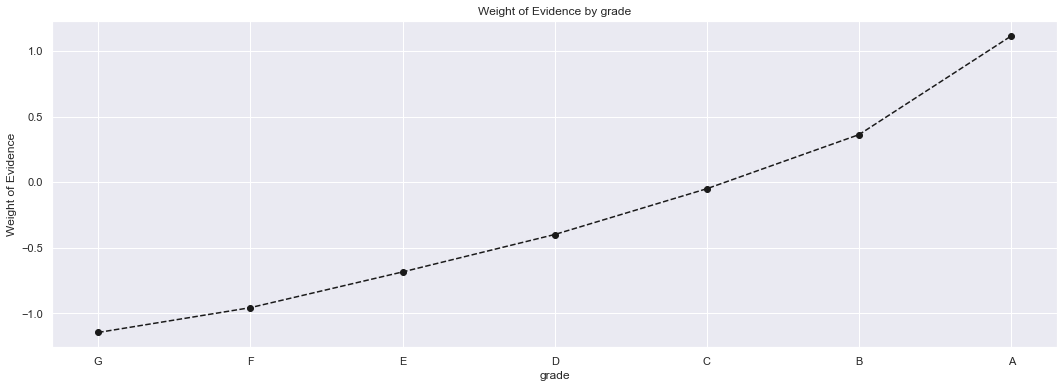

In [21]:
plot_by_woe(df_temp)

We can see from the above graph that there is a continuous increase in WoE across the different grades. Therefore, we do not need to combine any features together and should leave all these 7 grades as they are

Note that there are no missing values in the grade column, otherwise we would have created a separate and independent category for all Missing values, that would never be combined with any other category. We will come across this scenario when working through other features.

**home_ownership**

In [22]:
df_temp = woe_discrete(X_train_prepr, 'home_ownership', y_train_prepr)
df_temp

,home_ownership,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,OTHER,159,0.792453,0.000426,126.0,33.0,0.000379,0.000809,-0.758081,NaN,NaN,0.02166
1,NONE,41,0.853659,0.000110,35.0,6.0,0.000105,0.000147,-0.334267,0.061206,0.423814,0.02166
2,RENT,150776,0.874052,0.404195,131786.0,18990.0,0.396642,0.465738,-0.160588,0.020393,0.173678,0.02166
3,OWN,33313,0.890343,0.089304,29660.0,3653.0,0.089269,0.089591,-0.003605,0.016292,0.156984,0.02166
4,MORTGAGE,188739,0.904143,0.505965,170647.0,18092.0,0.513604,0.443714,0.146272,0.013800,0.149877,0.02166


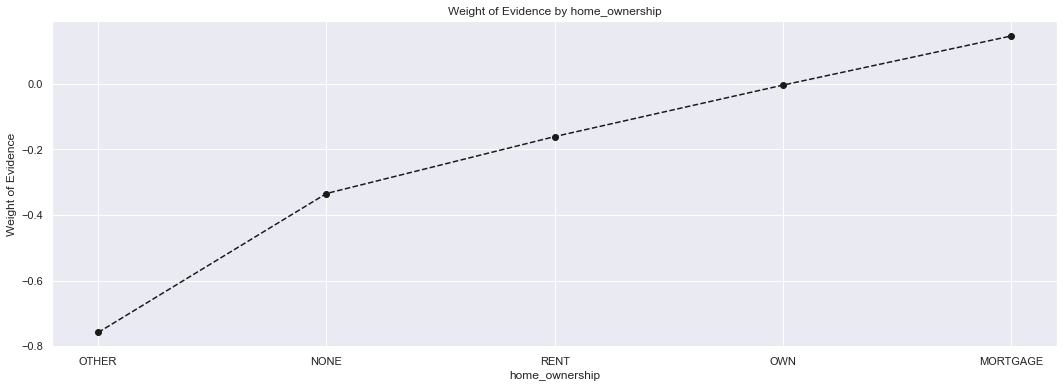

In [23]:
plot_by_woe(df_temp)

**verification_status**

In [24]:
df_temp = woe_discrete(X_train_prepr, 'verification_status', y_train_prepr)
df_temp

,verification_status,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,Verified,134571,0.872045,0.360753,117352.0,17219.0,0.353200,0.422303,-0.178691,NaN,NaN,0.022522
1,Source Verified,119969,0.895723,0.321609,107459.0,12510.0,0.323424,0.306813,0.052726,0.023678,0.231417,0.022522
2,Not Verified,118488,0.906784,0.317638,107443.0,11045.0,0.323376,0.270883,0.177128,0.011061,0.124402,0.022522


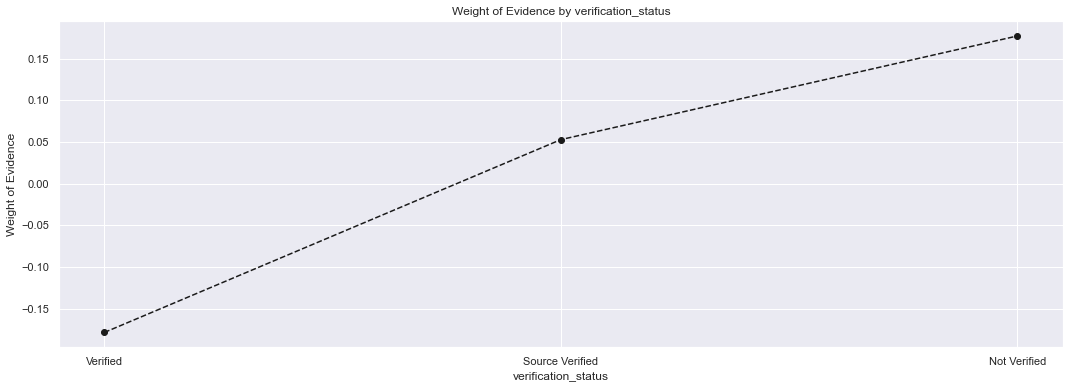

In [25]:
plot_by_woe(df_temp)

**purpose**

In [26]:
df_temp = woe_discrete(X_train_prepr, 'purpose', y_train_prepr)
df_temp

,purpose,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,small_business,5605,0.787333,0.015026,4413.0,1192.0,0.013282,0.029234,-0.788933,NaN,NaN,0.036668
1,educational,351,0.792023,0.000941,278.0,73.0,0.000837,0.001790,-0.760693,0.004690,0.028240,0.036668
2,renewable_energy,295,0.837288,0.000791,247.0,48.0,0.000743,0.001177,-0.459668,0.045265,0.301026,0.036668
3,moving,2397,0.848561,0.006426,2034.0,363.0,0.006122,0.008903,-0.374498,0.011273,0.085169,0.036668
4,house,1824,0.861294,0.004890,1571.0,253.0,0.004728,0.006205,-0.271777,0.012733,0.102721,0.036668
5,other,19006,0.861675,0.050951,16377.0,2629.0,0.049291,0.064477,-0.268581,0.000381,0.003196,0.036668
6,medical,3750,0.863467,0.010053,3238.0,512.0,0.009746,0.012557,-0.253469,0.001791,0.015112,0.036668
7,vacation,2003,0.875686,0.005370,1754.0,249.0,0.005279,0.006107,-0.145654,0.012220,0.107815,0.036668
8,wedding,1900,0.881053,0.005093,1674.0,226.0,0.005038,0.005543,-0.095419,0.005366,0.050235,0.036668
9,debt_consolidation,219196,0.886704,0.587613,194362.0,24834.0,0.584980,0.609065,-0.040346,0.005652,0.055072,0.036668


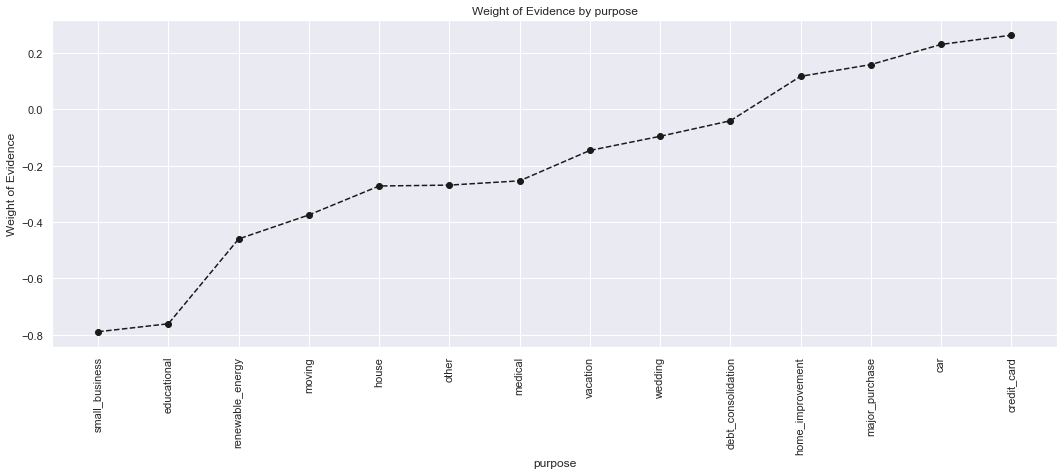

In [27]:
plot_by_woe(df_temp, 90)

### Analyze WoEs and IVs of numeric features

In [28]:
# We define a function to calculate WoE of continuous variables. This is same as the function we defined earlier for discrete variables.
# The only difference are the 2 commented lines of code in the function that results in the df being sorted by continuous variable values
def woe_ordered_continuous(df, continuous_variabe_name, y_df):
    df = pd.concat([df[continuous_variabe_name], y_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    #df = df.sort_values(['WoE'])
    #df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

**term**

In [29]:
df_temp = woe_ordered_continuous(X_train_prepr, 'term', y_train_prepr)
df_temp

,term,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,36,270199,0.903238,0.72434,244054.0,26145.0,0.73454,0.641217,0.135876,NaN,NaN,0.040794
1,60,102829,0.857735,0.27566,88200.0,14629.0,0.26546,0.358783,-0.301254,0.045503,0.43713,0.040794


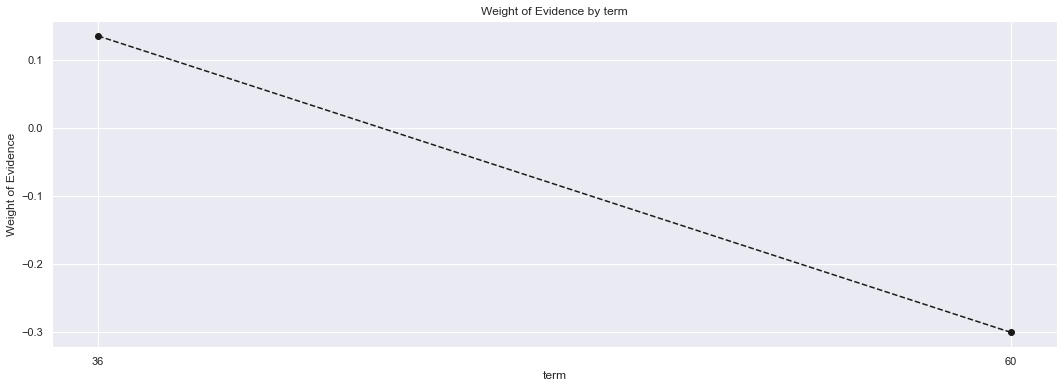

In [30]:
plot_by_woe(df_temp)

**int_rate_factor**

In [31]:
# fine-classing using the 'cut' method, given the large number of unique values
X_train_prepr['int_rate_factor'] = pd.cut(X_train_prepr['int_rate'], 50)
# Process 'int_rate_factor' column through woe_ordered_continuous and plot_by_woe functions
df_temp = woe_ordered_continuous(X_train_prepr, 'int_rate_factor', y_train_prepr)
df_temp.head(3)

,int_rate_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(5.399, 5.833]",776,0.962629,0.002080,747.0,29.0,0.002248,0.000711,1.150914,NaN,NaN,0.346603
1,"(5.833, 6.246]",8408,0.979305,0.022540,8234.0,174.0,0.024782,0.004267,1.759117,0.016677,0.608203,0.346603
2,"(6.246, 6.658]",7842,0.971181,0.021023,7616.0,226.0,0.022922,0.005543,1.419616,0.008125,0.339500,0.346603
3,"(6.658, 7.071]",1777,0.969612,0.004764,1723.0,54.0,0.005186,0.001324,1.364983,0.001569,0.054633,0.346603
4,"(7.071, 7.484]",3186,0.976146,0.008541,3110.0,76.0,0.009360,0.001864,1.613790,0.006534,0.248806,0.346603
5,"(7.484, 7.897]",12590,0.963781,0.033751,12134.0,456.0,0.036520,0.011184,1.183419,0.012365,0.430371,0.346603
6,"(7.897, 8.31]",9680,0.949483,0.025950,9191.0,489.0,0.027663,0.011993,0.835762,0.014297,0.347656,0.346603
7,"(8.31, 8.722]",6666,0.965047,0.017870,6433.0,233.0,0.019362,0.005714,1.220303,0.015563,0.384540,0.346603
8,"(8.722, 9.135]",9578,0.938923,0.025676,8993.0,585.0,0.027067,0.014347,0.634735,0.026124,0.585568,0.346603
9,"(9.135, 9.548]",6563,0.965565,0.017594,6337.0,226.0,0.019073,0.005543,1.235771,0.026642,0.601036,0.346603


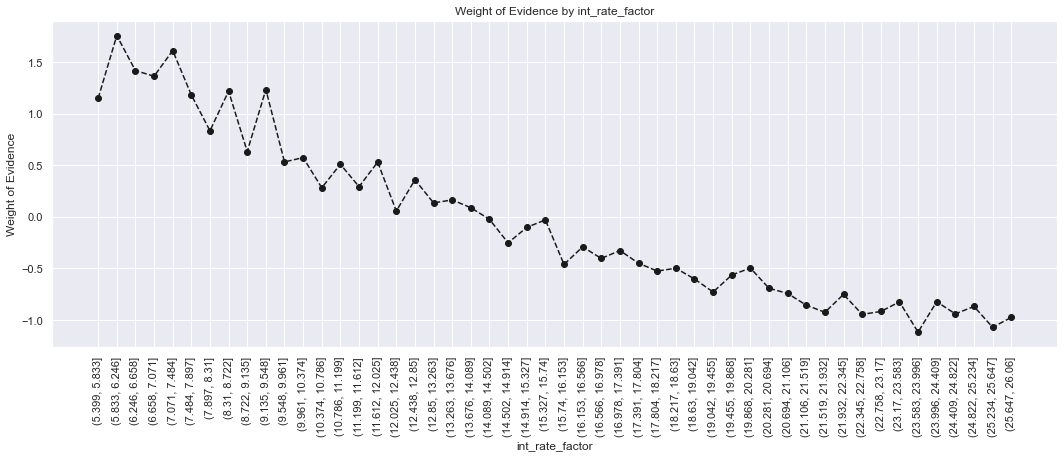

In [32]:
plot_by_woe(df_temp, 90)

**emp_length**

In [33]:
df_temp = woe_ordered_continuous(X_train_prepr, 'emp_length', y_train_prepr)
df_temp.head(3)

,emp_length,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,0.0,45764,0.876497,0.122682,40112.0,5652.0,0.120727,0.138618,-0.138189,NaN,NaN,0.006408
1,1.0,23582,0.888262,0.063218,20947.0,2635.0,0.063045,0.064625,-0.024743,0.011765,0.113446,0.006408
2,2.0,33123,0.889895,0.088795,29476.0,3647.0,0.088715,0.089444,-0.008184,0.001633,0.016559,0.006408
3,3.0,29301,0.890925,0.078549,26105.0,3196.0,0.078569,0.078383,0.002372,0.001030,0.010555,0.006408
4,4.0,22482,0.891602,0.060269,20045.0,2437.0,0.060330,0.059768,0.009357,0.000677,0.006985,0.006408
5,5.0,24654,0.885374,0.066092,21828.0,2826.0,0.065697,0.069309,-0.053524,0.006229,0.062881,0.006408
6,6.0,21057,0.883079,0.056449,18595.0,2462.0,0.055966,0.060382,-0.075936,0.002294,0.022413,0.006408
7,7.0,20834,0.887204,0.055851,18484.0,2350.0,0.055632,0.057635,-0.035365,0.004124,0.040571,0.006408
8,8.0,17859,0.889300,0.047876,15882.0,1977.0,0.047801,0.048487,-0.014249,0.002096,0.021116,0.006408
9,9.0,14372,0.887142,0.038528,12750.0,1622.0,0.038374,0.039780,-0.035984,0.002158,0.021735,0.006408


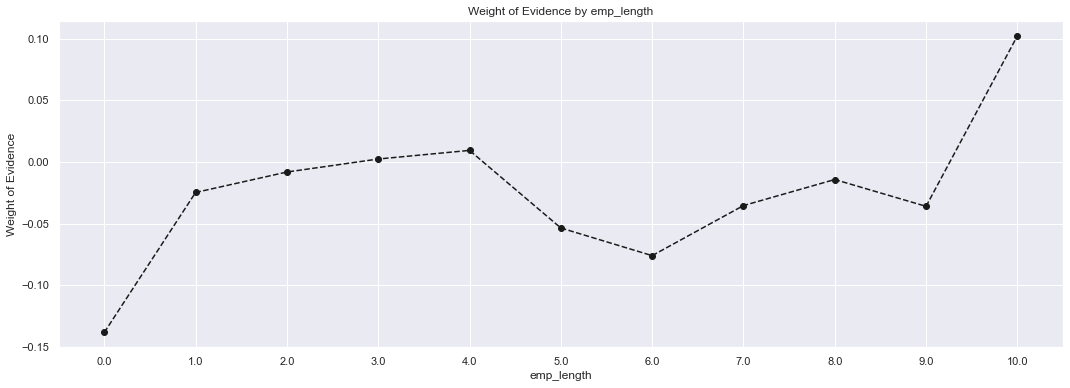

In [34]:
plot_by_woe(df_temp)

We will not use this feature for the following reasons:
- very low IV
- WoE ranges between a very small range, implying low power of differentiating between good and bad loans

**annual_inc_factor**

In [35]:
# fine-classing
X_train_prepr['annual_inc_factor'] = pd.cut(X_train_prepr['annual_inc'], 50)
# Process 'annual_inc_factor' column through woe_ordered_continuous and plot_by_woe functions
df_temp = woe_ordered_continuous(X_train_prepr, 'annual_inc_factor', y_train_prepr)
df_temp.head(3)

/Users/skhiearth/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:1926: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,annual_inc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-5602.104, 151858.08]",356629,0.889078,0.956048,317071.0,39558.0,0.954315,0.970177,-0.016485,NaN,NaN,inf
1,"(151858.08, 301820.16]",14796,0.925047,0.039665,13687.0,1109.0,0.041195,0.027199,0.415145,0.035969,0.431630,inf
2,"(301820.16, 451782.24]",1076,0.930297,0.002885,1001.0,75.0,0.003013,0.001839,0.493424,0.005250,0.078279,inf
3,"(451782.24, 601744.32]",291,0.941581,0.000780,274.0,17.0,0.000825,0.000417,0.682072,0.011283,0.188648,inf
4,"(601744.32, 751706.4]",96,0.906250,0.000257,87.0,9.0,0.000262,0.000221,0.170840,0.035331,0.511231,inf
5,"(751706.4, 901668.48]",59,0.932203,0.000158,55.0,4.0,0.000166,0.000098,0.523196,0.025953,0.352355,inf
6,"(901668.48, 1051630.56]",30,0.966667,0.000080,29.0,1.0,0.000087,0.000025,1.269453,0.034463,0.746257,inf
7,"(1051630.56, 1201592.64]",19,1.000000,0.000051,19.0,0.0,0.000057,0.000000,inf,0.033333,inf,inf
8,"(1201592.64, 1351554.72]",7,0.857143,0.000019,6.0,1.0,0.000018,0.000025,-0.306084,0.142857,inf,inf
9,"(1351554.72, 1501516.8]",5,1.000000,0.000013,5.0,0.0,0.000015,0.000000,inf,0.142857,inf,inf


In [36]:
# Initial examination shows that there are too few individuals with large income (up to $75m!!) and too many with small income.
# Since 95.6% of observations have income < 151,858, we will have one category for more than 150K, and we are going to apply our approach to determine
# the categories of everyone with 150k or less.
X_train_prepr_temp = X_train_prepr[X_train_prepr['annual_inc'] <= 150000].copy()
# fine-classing again
X_train_prepr_temp['annual_inc_factor'] = pd.cut(X_train_prepr_temp['annual_inc'], 50)
# make sure to select only the relevant indexes in the target column
df_temp = woe_ordered_continuous(X_train_prepr_temp, 'annual_inc_factor', y_train_prepr[X_train_prepr_temp.index])
df_temp.head(3)

,annual_inc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(1747.896, 4858.08]",16,0.812500,0.000045,13.0,3.0,0.000041,0.000076,-0.614889,NaN,NaN,0.04906
1,"(4858.08, 7820.16]",45,0.822222,0.000126,37.0,8.0,0.000117,0.000202,-0.549749,0.009722,0.065139,0.04906
2,"(7820.16, 10782.24]",342,0.847953,0.000959,290.0,52.0,0.000915,0.001315,-0.362589,0.025731,0.187161,0.04906
3,"(10782.24, 13744.32]",696,0.824713,0.001952,574.0,122.0,0.001811,0.003085,-0.532617,0.023241,0.170029,0.04906
4,"(13744.32, 16706.4]",1392,0.847701,0.003905,1180.0,212.0,0.003723,0.005361,-0.364542,0.022989,0.168075,0.04906
5,"(16706.4, 19668.48]",1908,0.849057,0.005352,1620.0,288.0,0.005111,0.007282,-0.354005,0.001355,0.010538,0.04906
6,"(19668.48, 22630.56]",3592,0.843820,0.010076,3031.0,561.0,0.009563,0.014185,-0.394299,0.005237,0.040294,0.04906
7,"(22630.56, 25592.64]",6450,0.859380,0.018093,5543.0,907.0,0.017489,0.022934,-0.271077,0.015560,0.123222,0.04906
8,"(25592.64, 28554.72]",5729,0.848316,0.016070,4860.0,869.0,0.015334,0.021973,-0.359775,0.011064,0.088698,0.04906
9,"(28554.72, 31516.8]",10353,0.858881,0.029041,8892.0,1461.0,0.028055,0.036942,-0.275195,0.010566,0.084580,0.04906


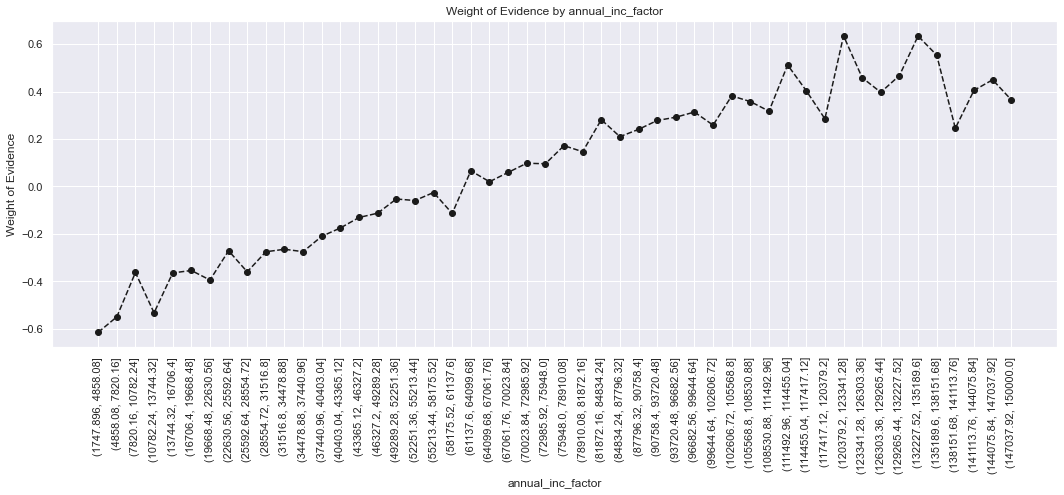

In [37]:
plot_by_woe(df_temp, 90)

**dti_factor**

In [38]:
# fine-classing
X_train_prepr['dti_factor'] = pd.cut(X_train_prepr['dti'], 50)
# Process 'annual_inc_factor' column through woe_ordered_continuous and plot_by_woe functions
df_temp = woe_ordered_continuous(X_train_prepr, 'dti_factor', y_train_prepr)
df_temp.head(3)

,dti_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.04, 0.8]",1537,0.901106,0.004120,1385.0,152.0,0.004168,0.003728,0.111720,NaN,NaN,0.027353
1,"(0.8, 1.6]",1966,0.902340,0.005270,1774.0,192.0,0.005339,0.004709,0.125642,0.001234,0.013922,0.027353
2,"(1.6, 2.399]",2507,0.909454,0.006721,2280.0,227.0,0.006862,0.005567,0.209126,0.007114,0.083484,0.027353
3,"(2.399, 3.199]",3257,0.910040,0.008731,2964.0,293.0,0.008921,0.007186,0.216267,0.000586,0.007142,0.027353
4,"(3.199, 3.999]",4095,0.909158,0.010978,3723.0,372.0,0.011205,0.009123,0.205536,0.000882,0.010731,0.027353
5,"(3.999, 4.799]",5059,0.917968,0.013562,4644.0,415.0,0.013977,0.010178,0.317198,0.008810,0.111662,0.027353
6,"(4.799, 5.599]",6017,0.909091,0.016130,5470.0,547.0,0.016463,0.013415,0.204730,0.008877,0.112468,0.027353
7,"(5.599, 6.398]",6825,0.910769,0.018296,6216.0,609.0,0.018709,0.014936,0.225209,0.001678,0.020479,0.027353
8,"(6.398, 7.198]",7712,0.914160,0.020674,7050.0,662.0,0.021219,0.016236,0.267662,0.003391,0.042454,0.027353
9,"(7.198, 7.998]",8679,0.914622,0.023266,7938.0,741.0,0.023891,0.018173,0.273561,0.000462,0.005899,0.027353


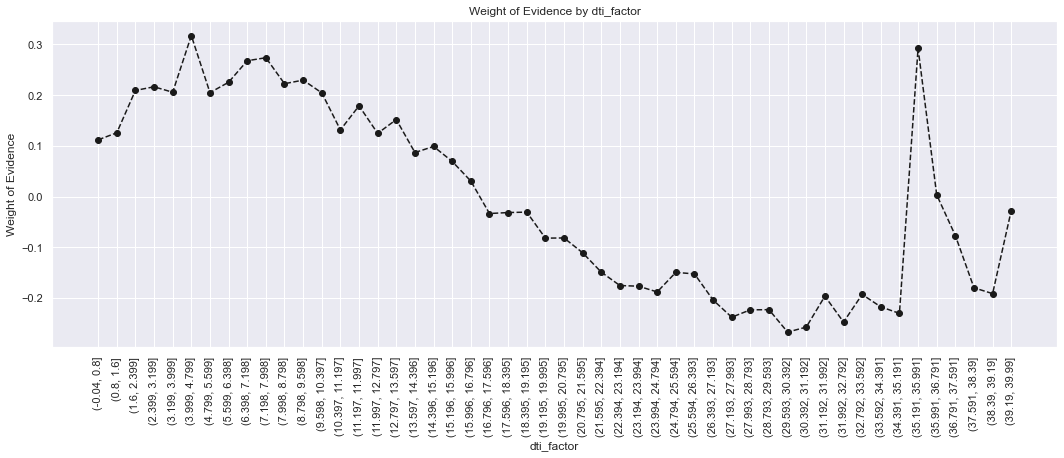

In [39]:
plot_by_woe(df_temp, 90)

**inq_last_6mths**

In [40]:
df_temp = woe_ordered_continuous(X_train_prepr, 'inq_last_6mths', y_train_prepr)
df_temp.head(3)

/Users/skhiearth/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/skhiearth/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:1926: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,inq_last_6mths,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,0.0,193162,0.908574,0.517856,175502.0,17660.0,0.528251,0.433151,0.198486,NaN,NaN,inf
1,1.0,104049,0.884814,0.278949,92064.0,11985.0,0.277108,0.293959,-0.059034,0.023760,0.257520,inf
2,2.0,46361,0.863679,0.124291,40041.0,6320.0,0.120521,0.155012,-0.251678,0.021135,0.192643,inf
3,3.0,20110,0.841174,0.053914,16916.0,3194.0,0.050916,0.078340,-0.430877,0.022505,0.179199,inf
4,4.0,5772,0.845807,0.015474,4882.0,890.0,0.014695,0.021829,-0.395774,0.004634,0.035103,inf
5,5.0,2218,0.825068,0.005946,1830.0,388.0,0.005508,0.009517,-0.546797,0.020740,0.151023,inf
6,6.0,960,0.792708,0.002574,761.0,199.0,0.002291,0.004881,-0.756534,0.032359,0.209737,inf
7,7.0,153,0.633987,0.000410,97.0,56.0,0.000292,0.001374,-1.548503,0.158721,0.791969,inf
8,8.0,98,0.632653,0.000263,62.0,36.0,0.000187,0.000883,-1.554247,0.001334,0.005744,inf
9,9.0,41,0.609756,0.000110,25.0,16.0,0.000075,0.000392,-1.651575,0.022897,0.097328,inf


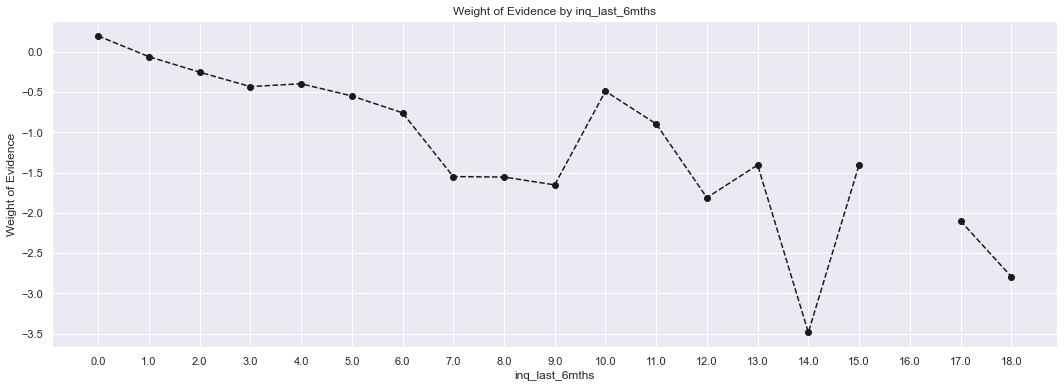

In [41]:
plot_by_woe(df_temp)

**revol_util**

In [42]:
# Initial examination shows that there are some obs with utilization of >1 times which should be very rare, so we will filter them out first
X_train_prepr_temp = X_train_prepr[X_train_prepr['revol_util'] <= 1].copy()
# fine-classing
X_train_prepr_temp['revol_util_factor'] = pd.cut(X_train_prepr_temp['revol_util'], 10)
# preprocess 'revol_util'
df_temp = woe_ordered_continuous(X_train_prepr_temp, 'revol_util_factor', y_train_prepr[X_train_prepr_temp.index])
df_temp.head(3)

,revol_util_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.001, 0.1]",1957,0.866633,0.656271,1696.0,261.0,0.643643,0.752161,-0.155806,NaN,NaN,0.090671
1,"(0.1, 0.2]",153,0.882353,0.051308,135.0,18.0,0.051233,0.051873,-0.012411,0.015720,0.143396,0.090671
2,"(0.2, 0.3]",136,0.941176,0.045607,128.0,8.0,0.048577,0.023055,0.745275,0.058824,0.757686,0.090671
3,"(0.3, 0.4]",111,0.882883,0.037223,98.0,13.0,0.037192,0.037464,-0.007296,0.058294,0.752571,0.090671
4,"(0.4, 0.5]",110,0.909091,0.036888,100.0,10.0,0.037951,0.028818,0.275271,0.026208,0.282567,0.090671
5,"(0.5, 0.6]",94,0.946809,0.031522,89.0,5.0,0.033776,0.014409,0.851885,0.037718,0.576613,0.090671
6,"(0.6, 0.7]",117,0.905983,0.039235,106.0,11.0,0.040228,0.031700,0.238230,0.040826,0.613655,0.090671
7,"(0.7, 0.8]",111,0.927928,0.037223,103.0,8.0,0.039089,0.023055,0.527974,0.021945,0.289744,0.090671
8,"(0.8, 0.9]",87,0.908046,0.029175,79.0,8.0,0.029981,0.023055,0.262693,0.019882,0.265281,0.090671
9,"(0.9, 1.0]",106,0.952830,0.035547,101.0,5.0,0.038330,0.014409,0.978369,0.044784,0.715676,0.090671


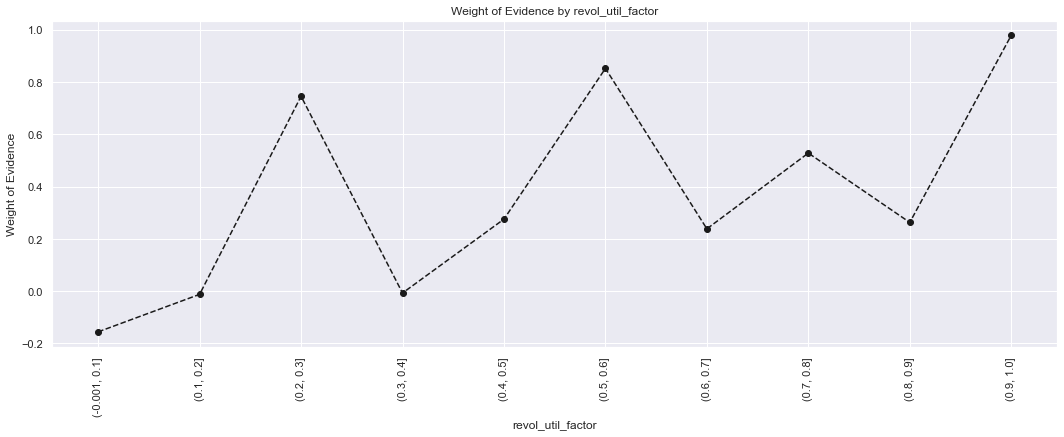

In [43]:
plot_by_woe(df_temp, 90)

**total_acc**

In [44]:
# Initial examination shows that there are some obs >50 accounts which should be very rare, so we will filter them out first
X_train_prepr_temp = X_train_prepr[X_train_prepr['total_acc'] <= 50].copy()
# fine-classing
X_train_prepr_temp['total_acc_factor'] = pd.cut(X_train_prepr_temp['total_acc'], 20)
# preprocess 'total_acc'
df_temp = woe_ordered_continuous(X_train_prepr_temp, 'total_acc_factor', y_train_prepr[X_train_prepr_temp.index])
df_temp.head(3)

,total_acc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(0.951, 3.45]",462,0.800866,0.001278,370.0,92.0,0.001149,0.002320,-0.702454,NaN,NaN,0.008031
1,"(3.45, 5.9]",3117,0.861084,0.008621,2684.0,433.0,0.008338,0.010921,-0.269843,6.021858e-02,0.432611,0.008031
2,"(5.9, 8.35]",11689,0.870990,0.032330,10181.0,1508.0,0.031627,0.038033,-0.184430,9.905443e-03,0.085413,0.008031
3,"(8.35, 10.8]",13426,0.876434,0.037134,11767.0,1659.0,0.036554,0.041841,-0.135085,5.443966e-03,0.049345,0.008031
4,"(10.8, 13.25]",28228,0.880402,0.078074,24852.0,3376.0,0.077203,0.085145,-0.097922,3.968652e-03,0.037163,0.008031
5,"(13.25, 15.7]",23108,0.882465,0.063913,20392.0,2716.0,0.063348,0.068499,-0.078186,2.062510e-03,0.019736,0.008031
6,"(15.7, 18.15]",38785,0.886683,0.107272,34390.0,4395.0,0.106832,0.110845,-0.036870,4.218049e-03,0.041316,0.008031
7,"(18.15, 20.6]",27039,0.886682,0.074785,23975.0,3064.0,0.074478,0.077276,-0.036878,7.962181e-07,0.000008,0.008031
8,"(20.6, 23.05]",40701,0.891673,0.112572,36292.0,4409.0,0.112741,0.111198,0.013781,4.991223e-03,0.050659,0.008031
9,"(23.05, 25.5]",25768,0.890407,0.071270,22944.0,2824.0,0.071275,0.071223,0.000734,1.266717e-03,0.013047,0.008031


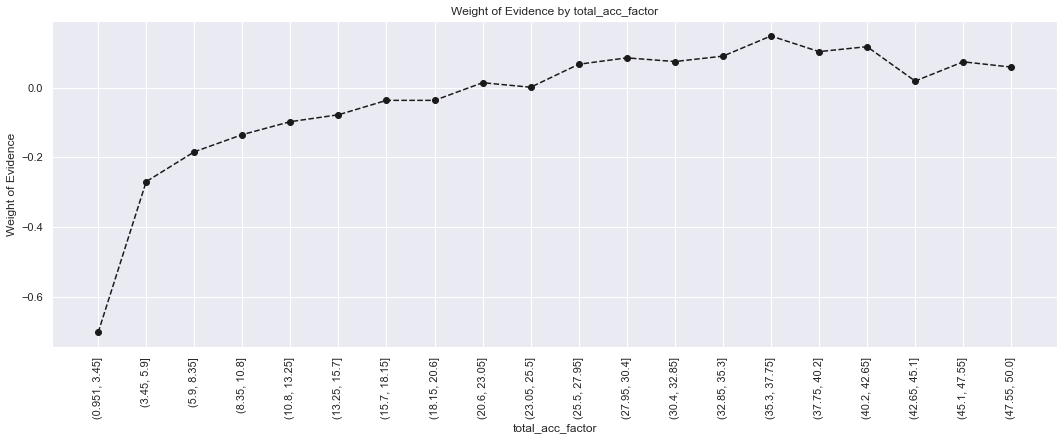

In [45]:
plot_by_woe(df_temp, 90)

We will discard this feature given its low IV

**out_prncp**

In [46]:
# Here we do fine-classing: using the 'cut' method, we split the variable into 25 categories by its values.
X_train_prepr['out_prncp_factor'] = pd.cut(X_train_prepr['out_prncp'], 25)
# We calculate weight of evidence.
df_temp = woe_ordered_continuous(X_train_prepr, 'out_prncp_factor', y_train_prepr)
df_temp.head(3)

,out_prncp_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-32.16, 1286.415]",196686,0.823078,0.527269,161888.0,34798.0,0.487242,0.853436,-0.560510,NaN,NaN,0.681688
1,"(1286.415, 2572.83]",19695,0.977558,0.052798,19253.0,442.0,0.057947,0.010840,1.676257,0.154479,2.236767,0.681688
2,"(2572.83, 3859.246]",21412,0.971511,0.057401,20802.0,610.0,0.062609,0.014961,1.431490,0.006046,0.244767,0.681688
3,"(3859.246, 5145.661]",17867,0.969217,0.047897,17317.0,550.0,0.052120,0.013489,1.351671,0.002294,0.079820,0.681688
4,"(5145.661, 6432.076]",14835,0.964341,0.039769,14306.0,529.0,0.043057,0.012974,1.199591,0.004876,0.152080,0.681688
5,"(6432.076, 7718.491]",13042,0.965649,0.034963,12594.0,448.0,0.037905,0.010987,1.238327,0.001308,0.038737,0.681688
6,"(7718.491, 9004.906]",13099,0.967860,0.035115,12678.0,421.0,0.038158,0.010325,1.307136,0.002211,0.068808,0.681688
7,"(9004.906, 10291.322]",12866,0.967744,0.034491,12451.0,415.0,0.037474,0.010178,1.303423,0.000116,0.003713,0.681688
8,"(10291.322, 11577.737]",9890,0.960061,0.026513,9495.0,395.0,0.028578,0.009688,1.081780,0.007684,0.221643,0.681688
9,"(11577.737, 12864.152]",9513,0.964785,0.025502,9178.0,335.0,0.027623,0.008216,1.212579,0.004724,0.130799,0.681688


The IV appears to be slightly higher than the recommended threshold (>0.5) but let's proceed nevertheless

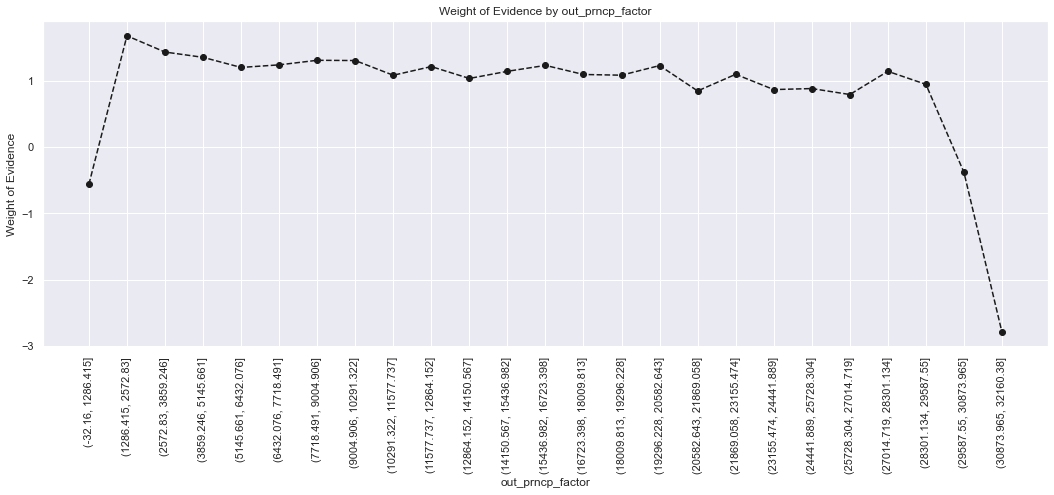

In [47]:
plot_by_woe(df_temp,90)

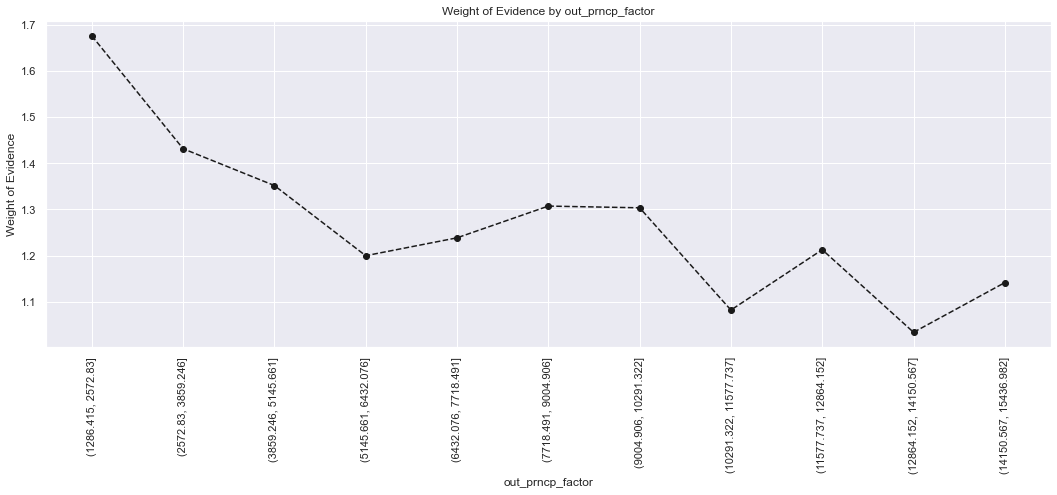

In [48]:
# We will zoom into the middle area to see more
plot_by_woe(df_temp.iloc[1:12,:],90)

**total_pymnt**

In [49]:
# Initial examination shows that there are vey few obs with >25,000 which should be very rare, so we will filter them out first
X_train_prepr_temp = X_train_prepr[X_train_prepr['total_pymnt'] <= 25000].copy()
# fine-classing
X_train_prepr_temp['total_pymnt_factor'] = pd.cut(X_train_prepr_temp['total_pymnt'], 20)
# preprocess 'total_acc'
df_temp = woe_ordered_continuous(X_train_prepr_temp, 'total_pymnt_factor', y_train_prepr[X_train_prepr_temp.index])
df_temp.head(3)

,total_pymnt_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-25.0, 1250.0]",5609,0.473881,0.016279,2658.0,2951.0,0.008734,0.073386,-2.128553,NaN,NaN,0.548419
1,"(1250.0, 2500.0]",16242,0.685753,0.047139,11138.0,5104.0,0.036597,0.126927,-1.243645,0.211872,0.884908,0.548419
2,"(2500.0, 3750.0]",25630,0.783145,0.074386,20072.0,5558.0,0.065952,0.138217,-0.739896,0.097392,0.503749,0.548419
3,"(3750.0, 5000.0]",30880,0.833873,0.089623,25750.0,5130.0,0.084609,0.127574,-0.410654,0.050728,0.329241,0.548419
4,"(5000.0, 6250.0]",33943,0.871432,0.098513,29579.0,4364.0,0.097190,0.108525,-0.110308,0.037558,0.300347,0.548419
5,"(6250.0, 7500.0]",32268,0.891843,0.093652,28778.0,3490.0,0.094558,0.086790,0.085726,0.020412,0.196034,0.548419
6,"(7500.0, 8750.0]",28052,0.896371,0.081416,25145.0,2907.0,0.082621,0.072292,0.133554,0.004528,0.047828,0.548419
7,"(8750.0, 10000.0]",24748,0.905245,0.071826,22403.0,2345.0,0.073612,0.058316,0.232926,0.008874,0.099372,0.548419
8,"(10000.0, 11250.0]",24596,0.925760,0.071385,22770.0,1826.0,0.074817,0.045409,0.499333,0.020515,0.266407,0.548419
9,"(11250.0, 12500.0]",21711,0.936392,0.063012,20330.0,1381.0,0.066800,0.034343,0.665306,0.010631,0.165974,0.548419


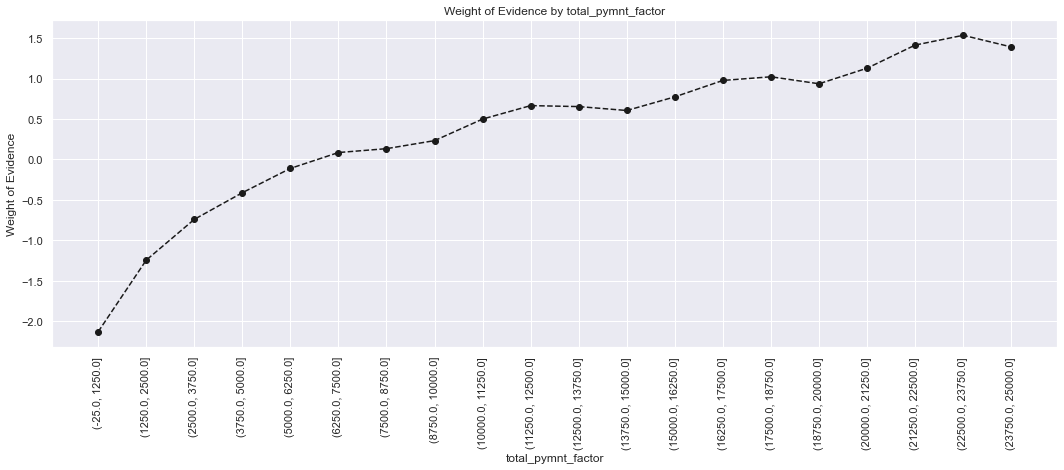

In [50]:
plot_by_woe(df_temp,90)

**total_rec_int**

In [51]:
# Initial examination shows that there are vey few obs with >7,261 which should be very rare, so we will filter them out first
X_train_prepr_temp = X_train_prepr[X_train_prepr['total_rec_int'] <= 7261].copy()
# fine-classing
X_train_prepr_temp['total_rec_int_factor'] = pd.cut(X_train_prepr_temp['total_rec_int'], 20)
# preprocess 'total_rec_int'
df_temp = woe_ordered_continuous(X_train_prepr_temp, 'total_rec_int_factor', y_train_prepr[X_train_prepr_temp.index])
df_temp.head(3)

,total_rec_int_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-7.261, 363.03]",22845,0.836594,0.064964,19112.0,3733.0,0.061078,0.096345,-0.455790,NaN,NaN,0.024917
1,"(363.03, 726.061]",41058,0.872546,0.116755,35825.0,5233.0,0.114489,0.135059,-0.165233,0.035952,0.290557,0.024917
2,"(726.061, 1089.092]",45720,0.890332,0.130013,40706.0,5014.0,0.130088,0.129407,0.005247,0.017786,0.170480,0.024917
3,"(1089.092, 1452.122]",41081,0.892797,0.116821,36677.0,4404.0,0.117212,0.113663,0.030742,0.002465,0.025495,0.024917
4,"(1452.122, 1815.152]",35526,0.896977,0.101024,31866.0,3660.0,0.101837,0.094461,0.075182,0.004180,0.044440,0.024917
5,"(1815.152, 2178.183]",30227,0.898601,0.085956,27162.0,3065.0,0.086804,0.079105,0.092877,0.001624,0.017695,0.024917
6,"(2178.183, 2541.214]",25037,0.898790,0.071197,22503.0,2534.0,0.071915,0.065400,0.094955,0.000189,0.002078,0.024917
7,"(2541.214, 2904.244]",20417,0.902532,0.058059,18427.0,1990.0,0.058889,0.051360,0.136788,0.003742,0.041833,0.024917
8,"(2904.244, 3267.274]",16480,0.899636,0.046864,14826.0,1654.0,0.047381,0.042688,0.104291,0.002896,0.032497,0.024917
9,"(3267.274, 3630.305]",13114,0.897819,0.037292,11774.0,1340.0,0.037627,0.034584,0.084330,0.001817,0.019962,0.024917


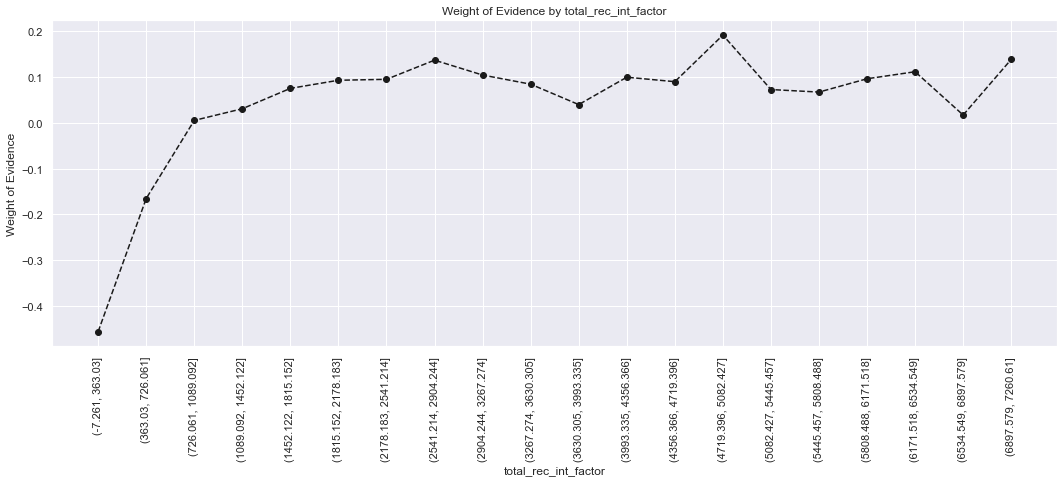

In [52]:
plot_by_woe(df_temp, 90)

**last_pymnt_amnt**

In [53]:
# Initial examination shows that there are vey few obs with 10,000 which should be very rare, so we will filter them out first
X_train_prepr_temp = X_train_prepr[X_train_prepr['last_pymnt_amnt'] <= 10000].copy()
# fine-classing
X_train_prepr_temp['last_pymnt_amnt_factor'] = pd.cut(X_train_prepr_temp['last_pymnt_amnt'], 15)
# preprocess
df_temp = woe_ordered_continuous(X_train_prepr_temp, 'last_pymnt_amnt_factor', y_train_prepr[X_train_prepr_temp.index])
df_temp

,last_pymnt_amnt_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-10.0, 666.667]",215272,0.843923,0.648462,181673.0,33599.0,0.623815,0.824637,-0.279089,NaN,NaN,1.036149
1,"(666.667, 1333.333]",46885,0.857865,0.141231,40221.0,6664.0,0.138108,0.163558,-0.169132,0.013942,0.109957,1.036149
2,"(1333.333, 2000.0]",6464,0.953434,0.019471,6163.0,301.0,0.021162,0.007388,1.052407,0.095569,1.221539,1.036149
3,"(2000.0, 2666.667]",6350,0.985197,0.019128,6256.0,94.0,0.021481,0.002307,2.231200,0.031762,1.178793,1.036149
4,"(2666.667, 3333.333]",6270,0.996332,0.018887,6247.0,23.0,0.021450,0.000565,3.637561,0.011135,1.406361,1.036149
5,"(3333.333, 4000.0]",6331,0.997473,0.019071,6315.0,16.0,0.021684,0.000393,4.011293,0.001141,0.373732,1.036149
6,"(4000.0, 4666.667]",6215,0.997908,0.018721,6202.0,13.0,0.021296,0.000319,4.200876,0.000436,0.189583,1.036149
7,"(4666.667, 5333.333]",6158,0.998701,0.018550,6150.0,8.0,0.021117,0.000196,4.677965,0.000793,0.477088,1.036149
8,"(5333.333, 6000.0]",5619,0.998932,0.016926,5613.0,6.0,0.019273,0.000147,4.874280,0.000231,0.196315,1.036149
9,"(6000.0, 6666.667]",5189,0.999615,0.015631,5187.0,2.0,0.017811,0.000049,5.893962,0.000682,1.019682,1.036149


Discard this feature given the abnormally high IV value

**tot_cur_bal**

In [54]:
# Again, because of very few obs > 64,000, we will filter them out first
X_train_prepr_temp = X_train_prepr[X_train_prepr['tot_cur_bal'] <= 64000].copy()
# fine-classing
X_train_prepr_temp['tot_cur_bal_factor'] = pd.cut(X_train_prepr_temp['tot_cur_bal'], 25)
# preprocess
df_temp = woe_ordered_continuous(X_train_prepr_temp, 'tot_cur_bal_factor', y_train_prepr[X_train_prepr_temp.index])
df_temp

,tot_cur_bal_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-64.0, 2560.0]",1778,0.902700,0.012373,1605.0,173.0,0.012617,0.010492,0.184381,NaN,NaN,0.00311
1,"(2560.0, 5120.0]",4621,0.897425,0.032158,4147.0,474.0,0.032600,0.028748,0.125727,0.005275,0.058654,0.00311
2,"(5120.0, 7680.0]",6453,0.897567,0.044907,5792.0,661.0,0.045531,0.040090,0.127273,0.000142,0.001546,0.00311
3,"(7680.0, 10240.0]",7500,0.887867,0.052193,6659.0,841.0,0.052347,0.051007,0.025927,0.009700,0.101346,0.00311
4,"(10240.0, 12800.0]",7949,0.883759,0.055317,7025.0,924.0,0.055224,0.056041,-0.014688,0.004108,0.040615,0.00311
5,"(12800.0, 15360.0]",8321,0.882706,0.057906,7345.0,976.0,0.057739,0.059195,-0.024894,0.001053,0.010206,0.00311
6,"(15360.0, 17920.0]",8342,0.888036,0.058052,7408.0,934.0,0.058234,0.056647,0.027633,0.005330,0.052527,0.00311
7,"(17920.0, 20480.0]",8406,0.878420,0.058498,7384.0,1022.0,0.058046,0.061984,-0.065652,0.009616,0.093285,0.00311
8,"(20480.0, 23040.0]",8246,0.880669,0.057384,7262.0,984.0,0.057087,0.059680,-0.044422,0.002249,0.021231,0.00311
9,"(23040.0, 25600.0]",8260,0.880993,0.057482,7277.0,983.0,0.057205,0.059619,-0.041342,0.000323,0.003080,0.00311


Ignore this feature given the low IV value

**total_rev_hi_lim**

In [55]:
# initial examination reveals very few obs > 79,780, we will filter them out first
X_train_prepr_temp = X_train_prepr[X_train_prepr['total_rev_hi_lim'] <= 79780].copy()
# fine-classing
X_train_prepr_temp['total_rev_hi_lim_factor'] = pd.cut(X_train_prepr_temp['total_rev_hi_lim'], 25)
# preprocess
df_temp = woe_ordered_continuous(X_train_prepr_temp, 'total_rev_hi_lim_factor', y_train_prepr[X_train_prepr_temp.index])
df_temp

,total_rev_hi_lim_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-79.767, 3190.68]",3574,0.866256,0.011821,3096.0,478.0,0.011419,0.015309,-0.293149,NaN,NaN,0.022189
1,"(3190.68, 6381.36]",14632,0.880331,0.048394,12881.0,1751.0,0.047509,0.056079,-0.165838,1.407449e-02,0.127311,0.022189
2,"(6381.36, 9572.04]",24622,0.885306,0.081435,21798.0,2824.0,0.080397,0.090443,-0.117740,4.975042e-03,0.048098,0.022189
3,"(9572.04, 12762.72]",29008,0.885790,0.095941,25695.0,3313.0,0.094771,0.106104,-0.112962,4.843028e-04,0.004778,0.022189
4,"(12762.72, 15953.4]",29826,0.887481,0.098647,26470.0,3356.0,0.097629,0.107481,-0.096142,1.690595e-03,0.016820,0.022189
5,"(15953.4, 19144.08]",28069,0.888703,0.092836,24945.0,3124.0,0.092005,0.100051,-0.083845,1.222118e-03,0.012297,0.022189
6,"(19144.08, 22334.76]",25057,0.893762,0.082874,22395.0,2662.0,0.082599,0.085255,-0.031644,5.059383e-03,0.052201,0.022189
7,"(22334.76, 25525.44]",22187,0.893767,0.073381,19830.0,2357.0,0.073139,0.075487,-0.031598,4.397959e-06,0.000046,0.022189
8,"(25525.44, 28716.12]",19265,0.897898,0.063717,17298.0,1967.0,0.063800,0.062996,0.012677,4.131122e-03,0.044275,0.022189
9,"(28716.12, 31906.8]",16446,0.898760,0.054394,14781.0,1665.0,0.054517,0.053324,0.022113,8.618348e-04,0.009436,0.022189


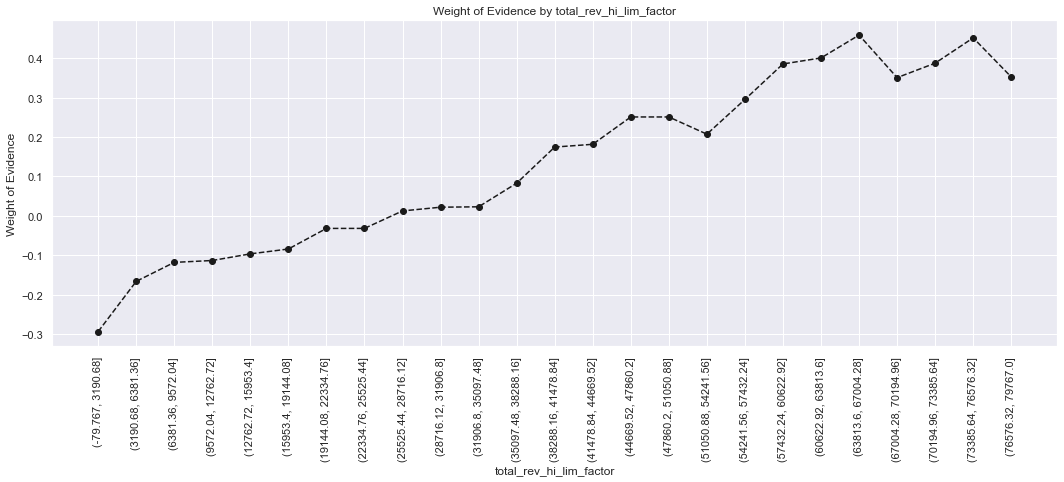

In [56]:
plot_by_woe(df_temp, 90)

**mths_since_earliest_cr_line_factor**

In [57]:
# fine-classing
X_train_prepr['mths_since_earliest_cr_line_factor'] = pd.cut(X_train_prepr['mths_since_earliest_cr_line'], 25)
# preprocess
df_temp = woe_ordered_continuous(X_train_prepr, 'mths_since_earliest_cr_line_factor', y_train_prepr)
df_temp

,mths_since_earliest_cr_line_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(104.486, 125.56]",2650,0.895094,0.007105,2372.0,278.0,0.007140,0.006819,0.046005,NaN,NaN,0.016102
1,"(125.56, 146.12]",6388,0.865529,0.017126,5529.0,859.0,0.016642,0.021069,-0.235869,0.029565,0.281874,0.016102
2,"(146.12, 166.68]",15672,0.862557,0.042016,13518.0,2154.0,0.040688,0.052832,-0.261167,0.002972,0.025298,0.016102
3,"(166.68, 187.24]",23403,0.873948,0.062742,20453.0,2950.0,0.061562,0.072355,-0.161538,0.011390,0.099629,0.016102
4,"(187.24, 207.8]",30963,0.882860,0.083010,27336.0,3627.0,0.082280,0.088960,-0.078064,0.008912,0.083474,0.016102
5,"(207.8, 228.36]",41418,0.886088,0.111039,36700.0,4718.0,0.110465,0.115720,-0.046471,0.003228,0.031593,0.016102
6,"(228.36, 248.92]",45873,0.884071,0.122983,40555.0,5318.0,0.122068,0.130436,-0.066301,0.002017,0.019830,0.016102
7,"(248.92, 269.48]",43012,0.888403,0.115313,38212.0,4800.0,0.115016,0.117731,-0.023329,0.004332,0.042972,0.016102
8,"(269.48, 290.04]",33146,0.891390,0.088863,29546.0,3600.0,0.088932,0.088298,0.007152,0.002986,0.030481,0.016102
9,"(290.04, 310.6]",28884,0.896794,0.077436,25903.0,2981.0,0.077967,0.073116,0.064238,0.005404,0.057085,0.016102


The IV is borderline close to the minimum ideal threshold, so we will proceed nevertheless

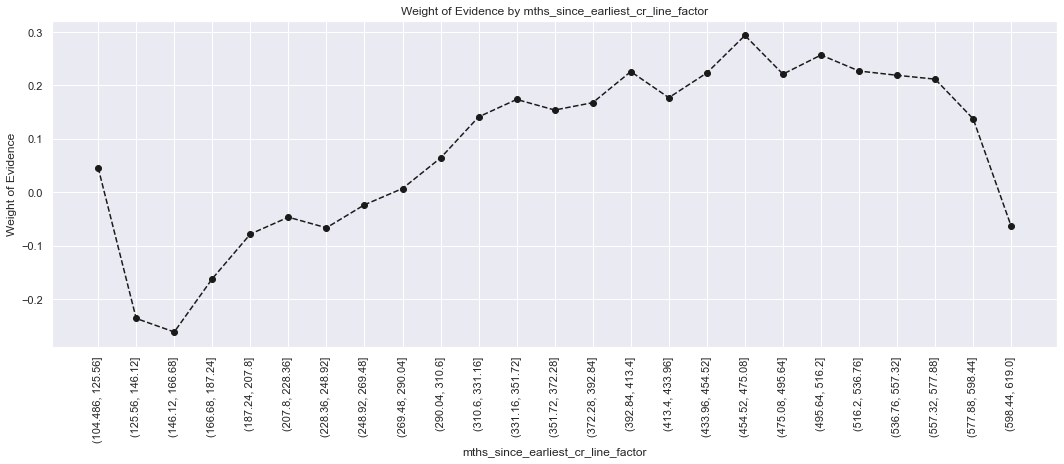

In [58]:
plot_by_woe(df_temp, 90)

**mths_since_issue_d_factor**

In [59]:
# fine-classing
X_train_prepr['mths_since_issue_d_factor'] = pd.cut(X_train_prepr['mths_since_issue_d'], 25)
# preprocess
df_temp = woe_ordered_continuous(X_train_prepr, "mths_since_issue_d_factor", y_train_prepr)
df_temp

,mths_since_issue_d_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(67.91, 71.6]",67865,0.934311,0.181930,63407.0,4458.0,0.190839,0.109334,0.557019,NaN,NaN,0.107728
1,"(71.6, 75.2]",67434,0.913145,0.180775,61577.0,5857.0,0.185331,0.143645,0.254796,0.021166,0.302223,0.107728
2,"(75.2, 78.8]",40680,0.900959,0.109053,36651.0,4029.0,0.110310,0.098813,0.110067,0.012186,0.144728,0.107728
3,"(78.8, 82.4]",47619,0.892837,0.127655,42516.0,5103.0,0.127962,0.125153,0.022197,0.008122,0.087871,0.107728
4,"(82.4, 86.0]",38870,0.874968,0.104201,34010.0,4860.0,0.102361,0.119194,-0.152239,0.017869,0.174436,0.107728
5,"(86.0, 89.6]",22337,0.862023,0.059880,19255.0,3082.0,0.057953,0.075587,-0.265663,0.012945,0.113424,0.107728
6,"(89.6, 93.2]",21530,0.856015,0.057717,18430.0,3100.0,0.055470,0.076029,-0.315277,0.006008,0.049614,0.107728
7,"(93.2, 96.8]",14249,0.849954,0.038198,12111.0,2138.0,0.036451,0.052435,-0.363612,0.006060,0.048334,0.107728
8,"(96.8, 100.4]",11976,0.832749,0.032105,9973.0,2003.0,0.030016,0.049124,-0.492620,0.017206,0.129008,0.107728
9,"(100.4, 104.0]",8304,0.834176,0.022261,6927.0,1377.0,0.020849,0.033772,-0.482336,0.001427,0.010284,0.107728


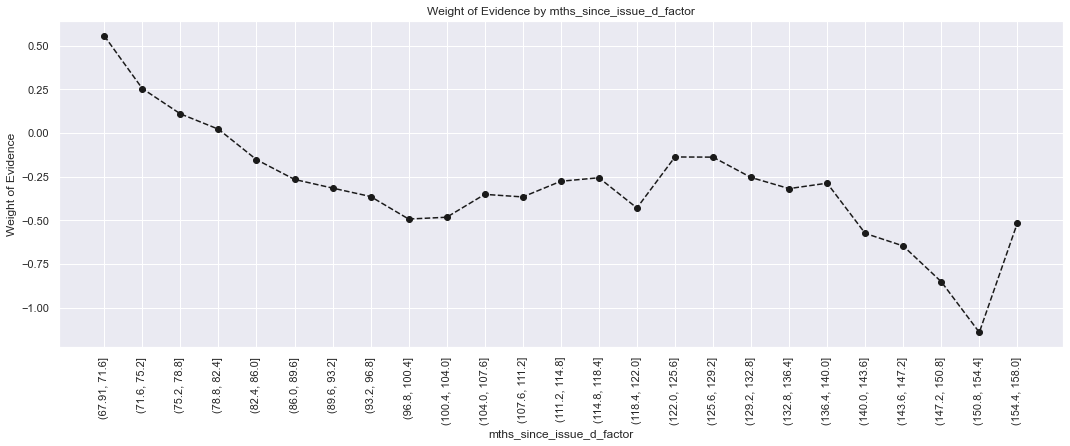

In [60]:
plot_by_woe(df_temp, 90)

**mths_since_last_pymnt_d_factor**

In [61]:
# fine-classing
X_train_prepr['mths_since_last_pymnt_d_factor'] = pd.cut(X_train_prepr['mths_since_last_pymnt_d'], 25)
# preprocess
df_temp = woe_ordered_continuous(X_train_prepr, "mths_since_last_pymnt_d_factor", y_train_prepr)
df_temp

,mths_since_last_pymnt_d_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(54.903, 58.88]",209784,0.977849,0.562851,205137.0,4647.0,0.617410,0.114846,1.681944,NaN,NaN,1.281457
1,"(58.88, 62.76]",33582,0.787922,0.090101,26460.0,7122.0,0.079638,0.176013,-0.793066,0.189927,2.475011,1.281457
2,"(62.76, 66.64]",30532,0.798637,0.081917,24384.0,6148.0,0.073390,0.151941,-0.727711,0.010715,0.065355,1.281457
3,"(66.64, 70.52]",23842,0.781394,0.063968,18630.0,5212.0,0.056072,0.128809,-0.831702,0.017243,0.103991,1.281457
4,"(70.52, 74.4]",19634,0.770908,0.052678,15136.0,4498.0,0.045556,0.111163,-0.892069,0.010487,0.060366,1.281457
5,"(74.4, 78.28]",13743,0.787164,0.036872,10818.0,2925.0,0.032559,0.072288,-0.797595,0.016257,0.094474,1.281457
6,"(78.28, 82.16]",9743,0.754080,0.026140,7347.0,2396.0,0.022113,0.059215,-0.985020,0.033085,0.187426,1.281457
7,"(82.16, 86.04]",7548,0.740991,0.020251,5593.0,1955.0,0.016834,0.048316,-1.054386,0.013089,0.069366,1.281457
8,"(86.04, 89.92]",4913,0.802565,0.013182,3943.0,970.0,0.011867,0.023973,-0.703111,0.061574,0.351275,1.281457
9,"(89.92, 93.8]",4373,0.771553,0.011733,3374.0,999.0,0.010155,0.024689,-0.888412,0.031012,0.185302,1.281457


Ignore this given the abnormally high IV value

**mths_since_last_credit_pull_d**

In [62]:
# filter out all values > 75 given the low obs
X_train_prepr_temp = X_train_prepr[X_train_prepr['mths_since_last_credit_pull_d'] <= 75].copy()
# Here we do fine-classing: using the 'cut' method, we split the variable into 25 categories
X_train_prepr_temp['mths_since_last_credit_pull_d_factor'] = pd.cut(X_train_prepr_temp['mths_since_last_credit_pull_d'], 25)
# Calculate WoE
df_temp = woe_ordered_continuous(X_train_prepr_temp, "mths_since_last_credit_pull_d_factor", y_train_prepr[X_train_prepr_temp.index])
df_temp

,mths_since_last_credit_pull_d_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(54.98, 55.8]",262140,0.920691,0.751391,241350.0,20790.0,0.769228,0.592021,0.261846,NaN,NaN,0.303394
1,"(55.8, 56.6]",11272,0.779010,0.032310,8781.0,2491.0,0.027987,0.070934,-0.930024,0.141681,1.191870,0.303394
2,"(56.6, 57.4]",6694,0.988348,0.019187,6616.0,78.0,0.021086,0.002221,2.250607,0.209338,3.180631,0.303394
3,"(57.4, 58.2]",6386,0.985437,0.018305,6293.0,93.0,0.020057,0.002648,2.024663,0.002911,0.225944,0.303394
4,"(58.2, 59.0]",6421,0.878056,0.018405,5638.0,783.0,0.017969,0.022297,-0.215778,0.107381,2.240442,0.303394
5,"(59.0, 59.8]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.303394
6,"(59.8, 60.6]",5283,0.841946,0.015143,4448.0,835.0,0.014177,0.023778,-0.517152,NaN,NaN,0.303394
7,"(60.6, 61.4]",5900,0.851525,0.016912,5024.0,876.0,0.016012,0.024945,-0.443315,0.009580,0.073838,0.303394
8,"(61.4, 62.2]",4958,0.838040,0.014211,4155.0,803.0,0.013243,0.022866,-0.546217,0.013486,0.102903,0.303394
9,"(62.2, 63.0]",4261,0.833607,0.012214,3552.0,709.0,0.011321,0.020190,-0.578520,0.004432,0.032302,0.303394


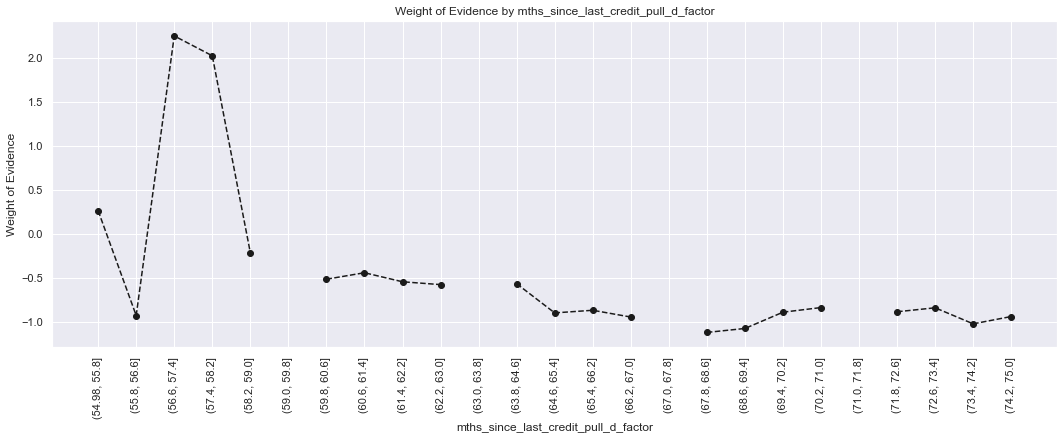

In [63]:
plot_by_woe(df_temp, 90)

### Define Custom Class for WoE Binning/Reengineering

Here we will create a custom scikit-learn class to take care of all binning transformations on any given data set. This custom class will help us in performing k fold cross validation

In [64]:
# create a list of all the reference categories, i.e. one category from each of the global features
ref_categories = ['mths_since_last_credit_pull_d:>75', 'mths_since_issue_d:>122', 'mths_since_earliest_cr_line:>434', 'total_rev_hi_lim:>79,780', 
                  'total_rec_int:>7,260', 'total_pymnt:>25,000', 'out_prncp:>15,437', 'revol_util:>1.0', 'inq_last_6mths:>4', 'dti:>35.191', 
                  'annual_inc:>150K', 'int_rate:>20.281', 'term:60', 'purpose:major_purch__car__home_impr', 'verification_status:Not Verified', 
                  'home_ownership:MORTGAGE', 'grade:G']

In [65]:
# This custom class will create new categorical dummy features based on the cut-off points that we manually identified
# based on the WoE plots and IV above.
# Given the way it is structured, this class also allows a fit_transform method to be implemented on it, thereby allowing 
# us to use it as part of a scikit-learn Pipeline 
class WoE_Binning(BaseEstimator, TransformerMixin):
    def __init__(self, X): # no *args or *kargs
        self.X = X
    def fit(self, X, y = None):
        return self #nothing else to do
    def transform(self, X):
        X_new = X.loc[:, 'grade:A': 'grade:G']
        X_new['home_ownership:OWN'] = X.loc[:,'home_ownership:OWN']
        X_new['home_ownership:MORTGAGE'] = X.loc[:,'home_ownership:MORTGAGE']
        X_new['home_ownership:OTHER_NONE_RENT'] = sum([X['home_ownership:OTHER'], X['home_ownership:NONE'], X['home_ownership:RENT']])
        X_new = pd.concat([X_new, X.loc[:, 'verification_status:Not Verified':'verification_status:Verified']], axis = 1)
        # For the purpose of this column, we keep debt_consolidation (due to volume) and credit_card (due to unique characteristics) as separate cateogories
        # These categories have very few observations: educational, renewable_energy, vacation, house, wedding, car
        # car is the least risky so we will combine it with the other 2 least risky categories: home_improvement and major_purchase
        # educational, renewable_energy (both low observations) will be combined with small_business and moving
        # vacation, house and wedding (remaining 3 with low observations) will be combined with medical and other
        X_new['purpose:debt_consolidation'] = X.loc[:,'purpose:debt_consolidation']
        X_new['purpose:credit_card'] = X.loc[:,'purpose:credit_card']
        X_new['purpose:major_purch__car__home_impr'] = sum([X['purpose:major_purchase'], X['purpose:car'], X['purpose:home_improvement']])
        X_new['purpose:educ__ren_en__sm_b__mov'] = sum([X['purpose:educational'], X['purpose:renewable_energy'], X['purpose:small_business'], 
                                                        X['purpose:moving']])
        X_new['purpose:vacation__house__wedding__med__oth'] = sum([X['purpose:vacation'], X['purpose:house'], X['purpose:wedding'], 
                                                                   X['purpose:medical'], X['purpose:other']])
        X_new['term:36'] = np.where((X['term'] == 36), 1, 0)
        X_new['term:60'] = np.where((X['term'] == 60), 1, 0)
        X_new['int_rate:<7.071'] = np.where((X['int_rate'] <= 7.071), 1, 0)
        X_new['int_rate:7.071-10.374'] = np.where((X['int_rate'] > 7.071) & (X['int_rate'] <= 10.374), 1, 0)
        X_new['int_rate:10.374-13.676'] = np.where((X['int_rate'] > 10.374) & (X['int_rate'] <= 13.676), 1, 0)
        X_new['int_rate:13.676-15.74'] = np.where((X['int_rate'] > 13.676) & (X['int_rate'] <= 15.74), 1, 0)
        X_new['int_rate:15.74-20.281'] = np.where((X['int_rate'] > 15.74) & (X['int_rate'] <= 20.281), 1, 0)
        X_new['int_rate:>20.281'] = np.where((X['int_rate'] > 20.281), 1, 0)
        X_new['annual_inc:missing'] = np.where(X['annual_inc'].isnull(), 1, 0)
        X_new['annual_inc:<28,555'] = np.where((X['annual_inc'] <= 28555), 1, 0)
        X_new['annual_inc:28,555-37,440'] = np.where((X['annual_inc'] > 28555) & (X['annual_inc'] <= 37440), 1, 0)
        X_new['annual_inc:37,440-61,137'] = np.where((X['annual_inc'] > 37440) & (X['annual_inc'] <= 61137), 1, 0)
        X_new['annual_inc:61,137-81,872'] = np.where((X['annual_inc'] > 61137) & (X['annual_inc'] <= 81872), 1, 0)
        X_new['annual_inc:81,872-102,606'] = np.where((X['annual_inc'] > 81872) & (X['annual_inc'] <= 102606), 1, 0)
        X_new['annual_inc:102,606-120,379'] = np.where((X['annual_inc'] > 102606) & (X['annual_inc'] <= 120379), 1, 0)
        X_new['annual_inc:120,379-150,000'] = np.where((X['annual_inc'] > 120379) & (X['annual_inc'] <= 150000), 1, 0)
        X_new['annual_inc:>150K'] = np.where((X['annual_inc'] > 150000), 1, 0)
        X_new['dti:<=1.6'] = np.where((X['dti'] <= 1.6), 1, 0)
        X_new['dti:1.6-5.599'] = np.where((X['dti'] > 1.6) & (X['dti'] <= 5.599), 1, 0)
        X_new['dti:5.599-10.397'] = np.where((X['dti'] > 5.599) & (X['dti'] <= 10.397), 1, 0)
        X_new['dti:10.397-15.196'] = np.where((X['dti'] > 10.397) & (X['dti'] <= 15.196), 1, 0)
        X_new['dti:15.196-19.195'] = np.where((X['dti'] > 15.196) & (X['dti'] <= 19.195), 1, 0)
        X_new['dti:19.195-24.794'] = np.where((X['dti'] > 19.195) & (X['dti'] <= 24.794), 1, 0)
        X_new['dti:24.794-35.191'] = np.where((X['dti'] > 24.794) & (X['dti'] <= 35.191), 1, 0)
        X_new['dti:>35.191'] = np.where((X['dti'] > 35.191), 1, 0)
        X_new['inq_last_6mths:missing'] = np.where(X['inq_last_6mths'].isnull(), 1, 0)
        X_new['inq_last_6mths:0'] = np.where((X['inq_last_6mths'] == 0), 1, 0)
        X_new['inq_last_6mths:1-2'] = np.where((X['inq_last_6mths'] >= 1) & (X['inq_last_6mths'] <= 2), 1, 0)
        X_new['inq_last_6mths:3-4'] = np.where((X['inq_last_6mths'] >= 3) & (X['inq_last_6mths'] <= 4), 1, 0)
        X_new['inq_last_6mths:>4'] = np.where((X['inq_last_6mths'] > 4), 1, 0)
        # We will discretize on the deciles for revol_util
        X_new['revol_util:missing'] = np.where(X['revol_util'].isnull(), 1, 0)
        X_new['revol_util:<0.1'] = np.where((X['revol_util'] <= 0.1), 1, 0)
        X_new['revol_util:0.1-0.2'] = np.where((X['revol_util'] > 0.1) & (X['revol_util'] <= 0.2), 1, 0)
        X_new['revol_util:0.2-0.3'] = np.where((X['revol_util'] > 0.2) & (X['revol_util'] <= 0.3), 1, 0)
        X_new['revol_util:0.3-0.4'] = np.where((X['revol_util'] > 0.3) & (X['revol_util'] <= 0.4), 1, 0)
        X_new['revol_util:0.4-0.5'] = np.where((X['revol_util'] > 0.4) & (X['revol_util'] <= 0.5), 1, 0)
        X_new['revol_util:0.5-0.6'] = np.where((X['revol_util'] > 0.5) & (X['revol_util'] <= 0.6), 1, 0)
        X_new['revol_util:0.6-0.7'] = np.where((X['revol_util'] > 0.6) & (X['revol_util'] <= 0.7), 1, 0)
        X_new['revol_util:0.7-0.8'] = np.where((X['revol_util'] > 0.7) & (X['revol_util'] <= 0.8), 1, 0)
        X_new['revol_util:0.8-0.9'] = np.where((X['revol_util'] > 0.8) & (X['revol_util'] <= 0.9), 1, 0)
        X_new['revol_util:0.9-1.0'] = np.where((X['revol_util'] > 0.9) & (X['revol_util'] <= 1.0), 1, 0)
        X_new['revol_util:>1.0'] = np.where((X['revol_util'] > 1.0), 1, 0)
        X_new['out_prncp:<1,286'] = np.where((X['out_prncp'] <= 1286), 1, 0)
        X_new['out_prncp:1,286-6,432'] = np.where((X['out_prncp'] > 1286) & (X['out_prncp'] <= 6432), 1, 0)
        X_new['out_prncp:6,432-9,005'] = np.where((X['out_prncp'] > 6432) & (X['out_prncp'] <= 9005), 1, 0)
        X_new['out_prncp:9,005-10,291'] = np.where((X['out_prncp'] > 9005) & (X['out_prncp'] <= 10291), 1, 0)
        X_new['out_prncp:10,291-15,437'] = np.where((X['out_prncp'] > 10291) & (X['out_prncp'] <= 15437), 1, 0)
        X_new['out_prncp:>15,437'] = np.where((X['out_prncp'] > 15437), 1, 0)
        X_new['total_pymnt:<10,000'] = np.where((X['total_pymnt'] <= 10000), 1, 0)
        X_new['total_pymnt:10,000-15,000'] = np.where((X['total_pymnt'] > 10000) & (X['total_pymnt'] <= 15000), 1, 0)
        X_new['total_pymnt:15,000-20,000'] = np.where((X['total_pymnt'] > 15000) & (X['total_pymnt'] <= 20000), 1, 0)
        X_new['total_pymnt:20,000-25,000'] = np.where((X['total_pymnt'] > 20000) & (X['total_pymnt'] <= 25000), 1, 0)
        X_new['total_pymnt:>25,000'] = np.where((X['total_pymnt'] > 25000), 1, 0)
        X_new['total_rec_int:<1,089'] = np.where((X['total_rec_int'] <= 1089), 1, 0)
        X_new['total_rec_int:1,089-2,541'] = np.where((X['total_rec_int'] > 1089) & (X['total_rec_int'] <= 2541), 1, 0)
        X_new['total_rec_int:2,541-4,719'] = np.where((X['total_rec_int'] > 2541) & (X['total_rec_int'] <= 4719), 1, 0)
        X_new['total_rec_int:4,719-7,260'] = np.where((X['total_rec_int'] > 4719) & (X['total_rec_int'] <= 7260), 1, 0)
        X_new['total_rec_int:>7,260'] = np.where((X['total_rec_int'] > 7260), 1, 0)
        X_new['total_rev_hi_lim:missing'] = np.where(X['total_rev_hi_lim'].isnull(), 1, 0)
        X_new['total_rev_hi_lim:<6,381'] = np.where((X['total_rev_hi_lim'] <= 6381), 1, 0)
        X_new['total_rev_hi_lim:6,381-19,144'] = np.where((X['total_rev_hi_lim'] > 6381) & (X['total_rev_hi_lim'] <= 19144), 1, 0)
        X_new['total_rev_hi_lim:19,144-25,525'] = np.where((X['total_rev_hi_lim'] > 19144) & (X['total_rev_hi_lim'] <= 25525), 1, 0)
        X_new['total_rev_hi_lim:25,525-35,097'] = np.where((X['total_rev_hi_lim'] > 25525) & (X['total_rev_hi_lim'] <= 35097), 1, 0)
        X_new['total_rev_hi_lim:35,097-54,241'] = np.where((X['total_rev_hi_lim'] > 35097) & (X['total_rev_hi_lim'] <= 54241), 1, 0)
        X_new['total_rev_hi_lim:54,241-79,780'] = np.where((X['total_rev_hi_lim'] > 54241) & (X['total_rev_hi_lim'] <= 79780), 1, 0)
        X_new['total_rev_hi_lim:>79,780'] = np.where((X['total_rev_hi_lim'] > 79780), 1, 0)
        X_new['mths_since_earliest_cr_line:missing'] = np.where(X['mths_since_earliest_cr_line'].isnull(), 1, 0)
        X_new['mths_since_earliest_cr_line:<125'] = np.where((X['mths_since_earliest_cr_line'] <= 125), 1, 0)
        X_new['mths_since_earliest_cr_line:125-167'] = np.where((X['mths_since_earliest_cr_line'] > 125) & (X['mths_since_earliest_cr_line'] <= 167), 1, 0)
        X_new['mths_since_earliest_cr_line:167-249'] = np.where((X['mths_since_earliest_cr_line'] > 167) & (X['mths_since_earliest_cr_line'] <= 249), 1, 0)
        X_new['mths_since_earliest_cr_line:249-331'] = np.where((X['mths_since_earliest_cr_line'] > 249) & (X['mths_since_earliest_cr_line'] <= 331), 1, 0)
        X_new['mths_since_earliest_cr_line:331-434'] = np.where((X['mths_since_earliest_cr_line'] > 331) & (X['mths_since_earliest_cr_line'] <= 434), 1, 0)
        X_new['mths_since_earliest_cr_line:>434'] = np.where((X['mths_since_earliest_cr_line'] > 434), 1, 0)
        X_new['mths_since_issue_d:<79'] = np.where((X['mths_since_issue_d'] <= 79), 1, 0)
        X_new['mths_since_issue_d:79-89'] = np.where((X['mths_since_issue_d'] > 79) & (X['mths_since_issue_d'] <= 89), 1, 0)
        X_new['mths_since_issue_d:89-100'] = np.where((X['mths_since_issue_d'] > 89) & (X['mths_since_issue_d'] <= 100), 1, 0)
        X_new['mths_since_issue_d:100-122'] = np.where((X['mths_since_issue_d'] > 100) & (X['mths_since_issue_d'] <= 122), 1, 0)
        X_new['mths_since_issue_d:>122'] = np.where((X['mths_since_issue_d'] > 122), 1, 0)
        X_new['mths_since_last_credit_pull_d:missing'] = np.where(X['mths_since_last_credit_pull_d'].isnull(), 1, 0)
        X_new['mths_since_last_credit_pull_d:<56'] = np.where((X['mths_since_last_credit_pull_d'] <= 56), 1, 0)
        X_new['mths_since_last_credit_pull_d:56-61'] = np.where((X['mths_since_last_credit_pull_d'] > 56) & (X['mths_since_last_credit_pull_d'] <= 61), 1, 0)
        X_new['mths_since_last_credit_pull_d:61-75'] = np.where((X['mths_since_last_credit_pull_d'] > 61) & (X['mths_since_last_credit_pull_d'] <= 75), 1, 0)
        X_new['mths_since_last_credit_pull_d:>75'] = np.where((X['mths_since_last_credit_pull_d'] > 75), 1, 0)
        X_new.drop(columns = ref_categories, inplace = True)
        return X_new
# we could have also structured this class without the last drop statement and without creating categories out of the 
# feature categories. But doing the way we have done here allows us to keep a proper track of the categories, if required

# PD Model

In [66]:
# reconfirm shape of the 4 datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(373028, 51)
(373028,)
(93257, 51)
(93257,)


In [99]:
# define modeling pipeline
import pickle
reg = LogisticRegression(max_iter=1000, class_weight = 'balanced')
woe_transform = WoE_Binning(X)

pickle_out = open("woe_transform.pickle","wb")
pickle.dump(woe_transform, pickle_out)
pickle_out.close()

pipeline = Pipeline(steps=[('woe', woe_transform), ('model', reg)])

# define cross-validation criteria. RepeatedStratifiedKFold automatially takes care of the class imbalance while splitting
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

# fit and evaluate the logistic regression pipeline with cross-validation as defined in cv
scores = cross_val_score(pipeline, X_train, y_train, scoring = 'roc_auc', cv = cv)
AUROC = np.mean(scores)
GINI = AUROC * 2 - 1

# print the mean AUROC score and Gini
print('Mean AUROC: %.4f' % (AUROC))
print('Gini: %.4f' % (GINI))

Mean AUROC: 0.8658
Gini: 0.7316


In [68]:
# pretty impressive scores for the first time, now let's fit the pipeline on the whole training set
pipeline.fit(X_train, y_train)

Pipeline(steps=[('woe',
                 WoE_Binning(X=        loan_amnt  funded_amnt  funded_amnt_inv        term  int_rate  \
0            5000         5000           4975.0   36 months     10.65   
1            2500         2500           2500.0   60 months     15.27   
2            2400         2400           2400.0   36 months     15.96   
3           10000        10000          10000.0   36 months     13.49   
4            3000         3000           3000.0   60 months     12.69   
...           ...          ...              ...         ...       ...   
466280      18400        18400          18400.0   60 months     14.47   
466281      22000        22000          22000.0   60 months     19.97   
466282      20700        20700          20700.0   60 months     1...
        acc_now_delinq tot_coll_amt  tot_cur_bal  total_rev_hi_lim  
0                  0.0          NaN          NaN               NaN  
1                  0.0          NaN          NaN               NaN  
2           

In [69]:
# first create a transformed training set through our WoE_Binning custom class
X_train_woe_transformed = woe_transform.fit_transform(X_train)
# Store the column names in X_train as a list
feature_name = X_train_woe_transformed.columns.values
# Create a summary table of our logistic regression model
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
# Create a new column in the dataframe, called 'Coefficients', with row values the transposed coefficients from the 'LogisticRegression' model
summary_table['Coefficients'] = np.transpose(pipeline['model'].coef_)
# Increase the index of every row of the dataframe with 1 to store our model intercept in 1st row
summary_table.index = summary_table.index + 1
# Assign our model intercept to this new row
summary_table.loc[0] = ['Intercept', pipeline['model'].intercept_[0]]
# Sort the dataframe by index
summary_table.sort_index(inplace = True)
summary_table

,Feature name,Coefficients
0,Intercept,2.947677
1,grade:A,0.983437
2,grade:B,0.795755
3,grade:C,0.611871
4,grade:D,0.489484
...,...,...
80,mths_since_issue_d:100-122,-0.117934
81,mths_since_last_credit_pull_d:missing,0.607745
82,mths_since_last_credit_pull_d:<56,0.647764
83,mths_since_last_credit_pull_d:56-61,1.184075


# Prediction Time!

In [70]:
# make preditions on our test set
y_hat_test = pipeline.predict(X_test)
# get the predicted probabilities
y_hat_test_proba = pipeline.predict_proba(X_test)
# select the probabilities of only the positive class (class 1 - default) 
y_hat_test_proba = y_hat_test_proba[:][: , 1]

In [71]:
# we will now create a new DF with actual classes and the predicted probabilities
# create a temp y_test DF to reset its index to allow proper concaternation with y_hat_test_proba
y_test_temp = y_test.copy()
y_test_temp.reset_index(drop = True, inplace = True)
y_test_proba = pd.concat([y_test_temp, pd.DataFrame(y_hat_test_proba)], axis = 1)
# check the shape to make sure the number of rows is same as that in y_test
y_test_proba.shape

(93257, 2)

In [72]:
# Rename the columns
y_test_proba.columns = ['y_test_class_actual', 'y_hat_test_proba']
# Makes the index of one dataframe equal to the index of another dataframe.
y_test_proba.index = X_test.index
y_test_proba.head()

,y_test_class_actual,y_hat_test_proba
395346,1,0.321503
376583,1,0.902276
297790,1,0.598430
47347,1,0.752022
446772,0,0.088188


## Confusion Matrix and AUROC on Test Set

In [73]:
# assign a threshold value to differentiate good with bad
tr = 0.5
# crate a new column for the predicted class based on predicted probabilities and threshold
# We will determine this optimat threshold later in this project
y_test_proba['y_test_class_predicted'] = np.where(y_test_proba['y_hat_test_proba'] > tr, 1, 0)
# create the confusion matrix
confusion_matrix(y_test_proba['y_test_class_actual'], y_test_proba['y_test_class_predicted'], normalize = 'all')

array([[0.08842232, 0.02088851],
       [0.18709587, 0.7035933 ]])

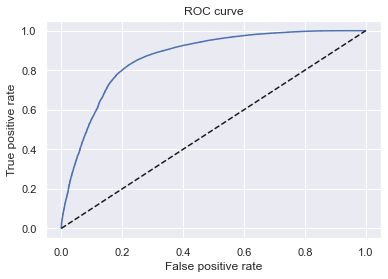

In [74]:
# get the values required to plot a ROC curve
fpr, tpr, thresholds = roc_curve(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
# plot the ROC curve
plt.plot(fpr, tpr)
# plot a secondary diagonal line, with dashed line style and black color to represent a no-skill classifier
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');

In [75]:
# Calculate the Area Under the Receiver Operating Characteristic Curve (AUROC) on our test set
AUROC = roc_auc_score(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
AUROC

0.8661600338620321

In [76]:
# calculate Gini from AUROC
Gini = AUROC * 2 - 1
Gini

0.7323200677240642

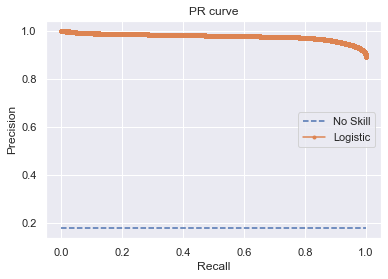

In [77]:
# draw a PR curve
# calculate the no skill line as the proportion of the positive class
no_skill = len(y_test[y_test == 1]) / len(y)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

# calculate inputs for the PR curve
precision, recall, thresholds = precision_recall_curve(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
# plot PR curve
plt.plot(recall, precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('PR curve');

In [78]:
# calculate PR AUC
auc_pr = auc(recall, precision)
auc_pr

0.97598257303971

# Applying the Model - Scorecard Creation

In [79]:
summary_table

,Feature name,Coefficients
0,Intercept,2.947677
1,grade:A,0.983437
2,grade:B,0.795755
3,grade:C,0.611871
4,grade:D,0.489484
...,...,...
80,mths_since_issue_d:100-122,-0.117934
81,mths_since_last_credit_pull_d:missing,0.607745
82,mths_since_last_credit_pull_d:<56,0.647764
83,mths_since_last_credit_pull_d:56-61,1.184075


In [80]:
# We create a new dataframe with one column. Its values are the values from the 'reference_categories' list. We name it 'Feature name'.
df_ref_categories = pd.DataFrame(ref_categories, columns = ['Feature name'])
# We create a second column, called 'Coefficients', which contains only 0 values.
df_ref_categories['Coefficients'] = 0
df_ref_categories

,Feature name,Coefficients
0,mths_since_last_credit_pull_d:>75,0
1,mths_since_issue_d:>122,0
2,mths_since_earliest_cr_line:>434,0
3,"total_rev_hi_lim:>79,780",0
4,"total_rec_int:>7,260",0
5,"total_pymnt:>25,000",0
6,"out_prncp:>15,437",0
7,revol_util:>1.0,0
8,inq_last_6mths:>4,0
9,dti:>35.191,0


In [81]:
# Concatenates two dataframes.
df_scorecard = pd.concat([summary_table, df_ref_categories])
# We reset the index of a dataframe.
df_scorecard.reset_index(inplace = True)
df_scorecard

,index,Feature name,Coefficients
0,0,Intercept,2.947677
1,1,grade:A,0.983437
2,2,grade:B,0.795755
3,3,grade:C,0.611871
4,4,grade:D,0.489484
...,...,...,...
97,12,term:60,0.000000
98,13,purpose:major_purch__car__home_impr,0.000000
99,14,verification_status:Not Verified,0.000000
100,15,home_ownership:MORTGAGE,0.000000


In [82]:
# create a new column, called 'Original feature name', which contains the value of the 'Feature name' column, up to the column symbol.
df_scorecard['Original feature name'] = df_scorecard['Feature name'].str.split(':').str[0]
df_scorecard

,index,Feature name,Coefficients,Original feature name
0,0,Intercept,2.947677,Intercept
1,1,grade:A,0.983437,grade
2,2,grade:B,0.795755,grade
3,3,grade:C,0.611871,grade
4,4,grade:D,0.489484,grade
...,...,...,...,...
97,12,term:60,0.000000,term
98,13,purpose:major_purch__car__home_impr,0.000000,purpose
99,14,verification_status:Not Verified,0.000000,verification_status
100,15,home_ownership:MORTGAGE,0.000000,home_ownership


In [83]:
# Define the min and max threshholds for our scorecard
min_score = 300
max_score = 850

In [84]:
# calculate the sum of the minimum coefficients of each category within the original feature name
min_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].min().sum()
# calculate the sum of the maximum coefficients of each category within the original feature name
max_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].max().sum()
# create a new columns that has the imputed calculated Score based on the multiplication of the coefficient by the ratio of the differences between
# maximum & minimum score and maximum & minimum sum of cefficients.
df_scorecard['Score - Calculation'] = df_scorecard['Coefficients'] * (max_score - min_score) / (max_sum_coef - min_sum_coef)
# update the calculated score of the Intercept (i.e. the default score for each loan)
df_scorecard.loc[0, 'Score - Calculation'] = ((df_scorecard.loc[0,'Coefficients'] - min_sum_coef) / (max_sum_coef - min_sum_coef)) * (max_score - min_score) + min_score
# round the values of the 'Score - Calculation' column and store them in a new column
df_scorecard['Score - Preliminary'] = df_scorecard['Score - Calculation'].round()
df_scorecard

,index,Feature name,Coefficients,Original feature name,Score - Calculation,Score - Preliminary
0,0,Intercept,2.947677,Intercept,598.621474,599.0
1,1,grade:A,0.983437,grade,24.554458,25.0
2,2,grade:B,0.795755,grade,19.868407,20.0
3,3,grade:C,0.611871,grade,15.277196,15.0
4,4,grade:D,0.489484,grade,12.221453,12.0
...,...,...,...,...,...,...
97,12,term:60,0.000000,term,0.000000,0.0
98,13,purpose:major_purch__car__home_impr,0.000000,purpose,0.000000,0.0
99,14,verification_status:Not Verified,0.000000,verification_status,0.000000,0.0
100,15,home_ownership:MORTGAGE,0.000000,home_ownership,0.000000,0.0


In [85]:
# check the min and max possible scores of our scorecard
min_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].min().sum()
max_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].max().sum()
print(min_sum_score_prel)
print(max_sum_score_prel)

301.0
852.0


In [86]:
# so both our min and max scores are out by +1. we need to manually adjust this
# Which one? We'll evaluate based on the rounding differences of the minimum category within each Original Feature Name.
df_scorecard['Difference'] = df_scorecard['Score - Preliminary'] - df_scorecard['Score - Calculation']

,index,Feature name,Coefficients,Original feature name,Score - Calculation,Score - Preliminary,Difference
0,0,Intercept,2.947677,Intercept,598.621474,599.0,0.378526
1,1,grade:A,0.983437,grade,24.554458,25.0,0.445542
2,2,grade:B,0.795755,grade,19.868407,20.0,0.131593
3,3,grade:C,0.611871,grade,15.277196,15.0,-0.277196
4,4,grade:D,0.489484,grade,12.221453,12.0,-0.221453
5,5,grade:E,0.333312,grade,8.322143,8.0,-0.322143
6,6,grade:F,0.191497,grade,4.781289,5.0,0.218711
7,7,home_ownership:OWN,-0.048261,home_ownership,-1.204970,-1.0,0.204970
8,8,home_ownership:OTHER_NONE_RENT,-0.104226,home_ownership,-2.602315,-3.0,-0.397685
9,9,verification_status:Source Verified,-0.281464,verification_status,-7.027608,-7.0,0.027608


In [87]:
# look like we can get by deducting 1 from the Intercept
df_scorecard['Score - Final'] = df_scorecard['Score - Preliminary']
df_scorecard.loc[0, 'Score - Final'] = 598

,index,Feature name,Coefficients,Original feature name,Score - Calculation,Score - Preliminary,Difference,Score - Final
0,0,Intercept,2.947677,Intercept,598.621474,599.0,0.378526,598.0
1,1,grade:A,0.983437,grade,24.554458,25.0,0.445542,25.0
2,2,grade:B,0.795755,grade,19.868407,20.0,0.131593,20.0
3,3,grade:C,0.611871,grade,15.277196,15.0,-0.277196,15.0
4,4,grade:D,0.489484,grade,12.221453,12.0,-0.221453,12.0
5,5,grade:E,0.333312,grade,8.322143,8.0,-0.322143,8.0
6,6,grade:F,0.191497,grade,4.781289,5.0,0.218711,5.0
7,7,home_ownership:OWN,-0.048261,home_ownership,-1.204970,-1.0,0.204970,-1.0
8,8,home_ownership:OTHER_NONE_RENT,-0.104226,home_ownership,-2.602315,-3.0,-0.397685,-3.0
9,9,verification_status:Source Verified,-0.281464,verification_status,-7.027608,-7.0,0.027608,-7.0


In [88]:
# Recheck min and max possible scores
print(df_scorecard.groupby('Original feature name')['Score - Final'].min().sum())
print(df_scorecard.groupby('Original feature name')['Score - Final'].max().sum())

300.0
851.0


In [93]:
df_scorecard.to_csv("scorecard.csv")

## Calculating credit scores for all observations in the test data set

In [89]:
# first create a transformed test set through our WoE_Binning custom class
X_test_woe_transformed = woe_transform.fit_transform(X_test)
# insert an Intercept column in its beginning to align with the # of rows in scorecard
X_test_woe_transformed.insert(0, 'Intercept', 1)
X_test_woe_transformed.head()

,Intercept,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:OTHER_NONE_RENT,verification_status:Source Verified,...,mths_since_earliest_cr_line:249-331,mths_since_earliest_cr_line:331-434,mths_since_issue_d:<79,mths_since_issue_d:79-89,mths_since_issue_d:89-100,mths_since_issue_d:100-122,mths_since_last_credit_pull_d:missing,mths_since_last_credit_pull_d:<56,mths_since_last_credit_pull_d:56-61,mths_since_last_credit_pull_d:61-75
395346,1,0,0,1,0,0,0,1,0,1,...,0,1,1,0,0,0,0,1,0,0
376583,1,1,0,0,0,0,0,0,1,0,...,1,0,1,0,0,0,0,1,0,0
297790,1,0,0,1,0,0,0,0,1,1,...,0,0,1,0,0,0,0,1,0,0
47347,1,0,1,0,0,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0,1
446772,1,0,0,0,1,0,0,0,0,1,...,0,1,1,0,0,0,0,0,0,1


In [90]:
# get the list of our final scorecard scores
scorecard_scores = df_scorecard['Score - Final']
# check the shapes of test set and scorecard before doing matrix dot multiplication
print(X_test_woe_transformed.shape)
print(scorecard_scores.shape)

(93257, 85)
(102,)


In [91]:
# we can see that the test set has 17 less columns than the rows in scorecard due to the reference categories
# since the reference categories will always be scored as 0 based on the scorecard, it is safe to add these categories to the end of test set with 0 values
X_test_woe_transformed = pd.concat([X_test_woe_transformed, pd.DataFrame(dict.fromkeys(ref_categories, [0] * len(X_test_woe_transformed)), 
                                                                         index = X_test_woe_transformed.index)], axis = 1)
# Need to reshape scorecard_scores so that it is (102,1) to allow for matrix dot multiplication
scorecard_scores = scorecard_scores.values.reshape(102, 1)
print(X_test_woe_transformed.shape)
print(scorecard_scores.shape)

(93257, 102)
(102, 1)


In [100]:
# matrix dot multiplication of test set with scorecard scores
y_scores = X_test_woe_transformed.dot(scorecard_scores)
y_scores.head()
y_scores.to_csv("scores.csv")